# Importing packages

['../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N2000D30.0ac6.0-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N2000D30.0ac4.0-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N1000D15.0ac1.0-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N2000D25.0ac1.0-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N500D10.0ac0.6-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N1000D15.0ac2.0-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Datasets/SumRuleCyl-allInOne-longest-last_10_pow_8_tsteps/N500D10.0ac0.8-bug-chainSize-longest-last_10_pow_8_tsteps.parquet.brotli', '../../Dataset

[out#0/mp4 @ 0x14461a520] Error writing trailer: Operation timed out
[out#0/mp4 @ 0x14461a520] Error closing file: Operation timed out


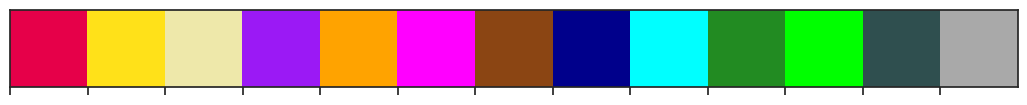

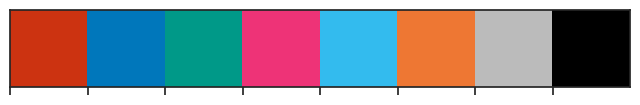

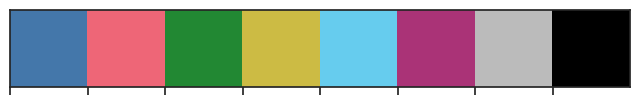

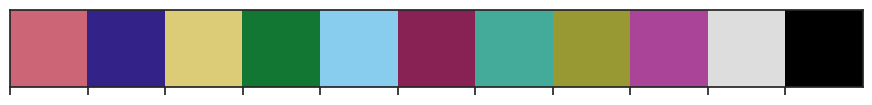

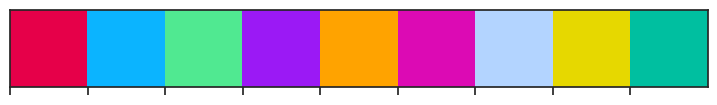

In [33]:
# Importing necessary packages:
%matplotlib inline
from glob import glob
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS_ORDER as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_BRIGHT as PTB
from polyphys.visualize.plotter import PAUL_TOL_VIBRANT as PTV
from polyphys.api import PROJECTS_DETAILS as PD_API
from polyphys.api import normalize_data

from polyphys.visualize import tuner
from polyphys.manage.parser import SumRuleCyl
from polyphys.manage import organizer
from polyphys.analyze import measurer
from polyphys.manage import utilizer

from PIL import Image
import imageio
from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm
import matplotlib.colors as mplcolors

import string
uppercase_letters = list(string.ascii_uppercase)

# Project details
project = 'SumRuleCyl'
project_details = PD_API[project]
# loading databases:
#allInOne_db = '../../Datasets/'+project+'-allInOne-*/' # relative
#allInOne_db = '../../Datasets/'+project+'-allInOne-4th_round/'
allInOne_db = '../../Datasets/'+project+'-allInOne-longest-last_10_pow_8_tsteps/' # relative
#allInOne_db = "/Users/amirhsi/research_data/analysis/"
#allInOne_db = '/Users/amirhsi_mini/research_data/do_not_delete/'+project+'-allInOne/' # relative

space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)
sns.palplot(AC)
sns.palplot(PTV)
sns.palplot(PTB)
sns.palplot(PTM)
sns.palplot(DF_colors)
#flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
#flare_cmap_cut = tuner.truncated_colormap(flar_cmap,  min_value=.1, max_value=1, ncolors=1000)
#mpl.cm.register_cmap("flare_cmap_cut", flare_cmap_cut)

# Merging datasets

## Time series

### Checking t_indexes

In [ ]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
space_names = [space.split('/')[-1].split('-')[0] for space in chainsize_space_dbs]
space_dbs.sort()
space_names.sort()
space_dict = dict(zip(chainsize_space_dbs,space_names))
space_2nd_round = ['N1000D15.0ac2.0', 'N2000D20.0ac2.0', 'N2000D25.0ac2.0',
                   'N2000D25.0ac4.0', 'N2000D25.0ac1.0', 'N1000D15.0ac1.0',
                   'N2000D20.0ac1.0']

space_3rd_round = ['N2000D120.0ac4.0', 'N2000D120.0ac6.0', 'N1000D120.0ac8.0']
space_4th_round = ['N2000D240.0ac4.0', 'N2000D240.0ac6.0', 'N1000D240.0ac8.0'] 
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    if space_dict[space_db] in space_2nd_round:
        t_cond = (chainsize['t_index']>=130000000)
    else:
        t_cond = (chainsize['t_index']>=200000000)
    chainsize = chainsize.loc[t_cond]
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    chainsize.reset_index(inplace=True, drop=True)
    print(chainsize.size)
    df = chainsize.groupby('ensemble_long')['t_index'].agg([np.min, np.max])
    print(df)
    

### New chain_space dataset based on the last 10^8 steps

In [ ]:
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
space_names = [space.split('/')[-1].split('-')[0] for space in chainsize_space_dbs]
space_dbs.sort()
space_names.sort()
space_dict = dict(zip(space_dbs,space_names))
space_2nd_round = ['N1000D15.0ac2.0', 'N2000D20.0ac2.0', 'N2000D25.0ac2.0',
                   'N2000D25.0ac4.0', 'N2000D25.0ac1.0', 'N1000D15.0ac1.0',
                   'N2000D20.0ac1.0']
group = 'bug'
save_to = '../../test_plots/'
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    chainsize = pd.read_parquet(space_db)
    if space_dict[space_db] in space_2nd_round:
        t_cond = (chainsize['t_index']>=130000000)
    else:
        t_cond = (chainsize['t_index']>=200000000)
    chainsize = chainsize.loc[t_cond]
    chainsize.reset_index(inplace=True, drop=True)
    output_name = save_to +  "-".join(
        [space_dict[space_db],project_details['group'], "chainSize-longest-last_10_pow_8_tsteps.parquet.brotli"]
    )
    chainsize.to_parquet(output_name, index=False, compression='brotli')

#### Averaging

In [ ]:
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
space_names = [space.split('/')[-1].split('-')[0] for space in chainsize_space_dbs]
space_dbs.sort()
space_names.sort()
space_dict = dict(zip(space_dbs,space_names))
space_2nd_round = ['N1000D15.0ac2.0', 'N2000D20.0ac2.0', 'N2000D25.0ac2.0',
                   'N2000D25.0ac4.0', 'N2000D25.0ac1.0', 'N1000D15.0ac1.0',
                   'N2000D20.0ac1.0']
group = 'bug'
save_to = '../../test_plots/'
equil_db = []
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    if space_dict[space_db] in space_2nd_round:
        t_cond = (chainsize['t_index']>=130000000)
    else:
        t_cond = (chainsize['t_index']>=200000000)
    chainsize = chainsize.loc[t_cond]
    # Group by 'phi_c_bulk_round'
    grouped = chainsize.groupby(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd', 'phi_c_bulk_round'])
    
    # Define the operations you want to perform
    operations = ['mean', 'var', 'sem']
    
    # Define the properties you want to calculate
    properties = ['fsd', 'gyr', 'asphericity', 'rflory', 'shape', 'transSize']
    
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame()
    
    # Iterate through properties and operations to calculate and rename columns
    for property in properties:
        for operation in operations:
            col_name = f'{property}Mon-{operation}'
            if operation == 'mean':
                result_df[col_name] = grouped[f'{property}TMon-{operation}'].mean()
            elif operation == 'var':
                result_df[col_name] = grouped[f'{property}TMon-{operation}'].var()
            elif operation == 'sem':
                result_df[col_name] = grouped[f'{property}TMon-{operation}'].mean()
    
    result_df.reset_index(inplace=True) 
    for property in properties:
        mean_col = property + 'Mon-mean'
        conds = (result_df['phi_c_bulk_round'] == 0)
        mean_value_phi_c_0 = result_df.loc[conds,mean_col]#.values[0]#[property_col]
        norm_col = f'{property}Mon-norm'
        result_df[norm_col] = result_df[mean_col] / mean_value_phi_c_0.values[0]
    equil_db.append(result_df)

# 'result_dataframes' now contains the processed dataframes for each original dataframe
equil_db = pd.concat(equil_db)
output = save_to + "-".join(
            ["allInOne", project, project_details['group'], "equilProps-ensAvg.csv"]
            )
equil_db.to_csv(output,index=False)

### Viz longest spaces 

In [ ]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
space_names = [space.split('/')[-1].split('-')[0] for space in chainsize_space_dbs]
space_dbs.sort()
space_names.sort()
space_dict = dict(zip(space_dbs,space_names))
space_2nd_round = ['N1000D15.0ac2.0', 'N2000D20.0ac2.0', 'N2000D25.0ac2.0',
                   'N2000D25.0ac4.0', 'N2000D25.0ac1.0', 'N1000D15.0ac1.0',
                   'N2000D20.0ac1.0']


save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'

for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    if space_dict[space_db] in space_2nd_round:
        t_cond = (chainsize['t_index']>=130000000)
        chainsize = chainsize.loc[t_cond]
    else:
        t_cond = (chainsize['t_index']>=200000000)
        chainsize = chainsize.loc[t_cond]
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    chainsize.reset_index(inplace=True, drop=True)
    # add rounded phi_crds to the dataset
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [
        prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
    ]
    properties.sort()
    # change the name of cols after fining properties based on "mean" in their name
    new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
    chainsize.columns = new_columns
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())

    for plot_context in ['paper']:#, 'talk']:
        for x_axis_style in ['normal']:#, 'log']:
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        grid = sns.lineplot(
                            data=chainsize,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            grid.set_title(
                                chainsize['space_title'].values[0],
                            )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop]['symbol'])
                        grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            grid.set(xscale="log")
                        output = "-".join(["Time_evolution", plot_context,
                                           x_axis_style, y_prop, project,
                                           space])
                        plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                        plt.close()

## Distributions

### New chain_space dataset based on the last 10^8 steps

In [ ]:
group = 'all'
directions = ['r','z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
dist = []

space_2nd_round = ['N1000D15.0ac2.0', 'N2000D20.0ac2.0', 'N2000D25.0ac2.0',
                   'N2000D25.0ac4.0', 'N2000D25.0ac1.0', 'N1000D15.0ac1.0',
                   'N2000D20.0ac1.0']

for direction, prop in dir_prop_pairs:
    p_name = direction + prop
    equil_db = '-'.join(
        ['allInOne', project, group, p_name]
    )
    equil_db += '-NormalizedScaled.parquet.brotli'
    # Distribution from 1st round
    allInOne_db = '../../Datasets/'+project+'-allInOne-1st_round/'
    print(equil_db) 
    local_dist_1st_round = pd.read_parquet(allInOne_db + equil_db)
    local_dist_1st_round = local_dist_1st_round.loc[~local_dist_1st_round['space'].isin(space_2nd_round)]
    # Distribution from 2nd round
    allInOne_db = '../../Datasets/'+project+'-allInOne-2nd_round/'
    print(equil_db)
    local_dist_2st_round = pd.read_parquet(allInOne_db + equil_db)
    local_dist = pd.concat([local_dist_1st_round,local_dist_2st_round],axis=0)
    allInOne_db = '../../Datasets/'+project+'-allInOne-longest/'
    output = '-'.join(['allInOne', project, group, direction + prop])
    output += '-NormalizedScaled.parquet.brotli'
    output = allInOne_db + output
    local_dist.to_parquet(output, index=False, compression='brotli')

# Confinement rate ($L/D$) and finite-size effects ($Z/L$)

In [ ]:
#allInOne_db = '../../Datasets/SumRuleCyl-allInOne/*equilProps-whole.csv'
allInOne_db = '/Users/amirhsi_mini/research_data/'+project+'-allInOne/'
allInOne_db = glob(allInOne_db)
print(allInOne_db)
equil = pd.read_csv(allInOne_db[0])
print(equil.columns)

In [ ]:
cols = ['n_frames','nmon','dcyl','dcrowd','lcyl','phi_c_bulk_round']
n_equilibrate = 1000000
dt_equilibrate = 0.02
n_dump = 2000
dt = 0.005
damp_melt = 43 # in inverse tau
mean_round = lambda x: np.round(np.mean(x),3)
flory_exponent = 0.588
pre_factor = 1.18 # free space size prefactor
a_const = 1.42 # prefactor for 1D size
x_const = 0.82 # prefactor for blob vs chain size

table_1 = equil.groupby(cols)[cols+['fsdMon-mean']].agg({'fsdMon-mean': mean_round})
table_1.reset_index(inplace=True)
table_1['lcyl/fsdMon'] = np.round(table_1['lcyl'] / table_1['fsdMon-mean'],3)
table_1['dt_equilibrate'] = dt_equilibrate
table_1['step_equilibrate'] = n_equilibrate
table_1['t_equilibrate'] = n_equilibrate * dt_equilibrate
table_1['dt_sampling'] = dt
table_1['step_sampling'] = n_dump * table_1['n_frames']
table_1['t_sampling'] = n_dump * dt * table_1['n_frames']
table_1['t_total'] = table_1['t_sampling'] + table_1['t_equilibrate']
table_1['t_rouse_free'] = pre_factor*table_1['nmon']**(1+2*flory_exponent)*damp_melt/3/np.pi**2
table_1['step_rouse_free'] = table_1['t_rouse_free']/dt
table_1['t_rouse_cylinder'] = (table_1['nmon']**(1.75)
                               *table_1['dcyl']**0.7)
table_1['step_rouse_cylinder'] = table_1['t_rouse_cylinder'] / dt
sort_cols = cols + ['lcyl/fsdMon']
table_1.sort_values(by=sort_cols,inplace=True)
table_1.to_csv(project+'size_lcyl_rouse_time.csv',index=False)

In [ ]:
pre_factor*2000**(1+2*flory_exponent)*damp_melt/3/np.pi**2/100000

In [ ]:
cols = ['nmon','dcyl','dcrowd']
mean_round = lambda x: np.round(np.mean(x),3)
table_2 = equil.groupby(cols)[['phi_c_bulk_round']].count()
table_2.reset_index(inplace=True)
#table_2['lcyl/fsdMon'] = np.round(table_1['lcyl'] / table_1['fsdMon-mean'],3)
#sort_cols = cols + ['lcyl/fsdMon']
table_2.sort_values(by=cols,inplace=True)
table_2.to_csv('table_2.csv',index=False)

# Analyze Log file

In [ ]:
# Load datasets
df = pd.read_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat-shorten.csv')
wall_time_df = pd.read_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-wallTimeStat.csv')

# Grouping and aggregation for the first dataset
new_grouped_df = df.groupby('whole').agg({
    'n_cores': 'last',
    'n_atoms': 'last',
    'space': 'last',
    'ensemble_long': 'last',
    'loop_idx': 'count',
    'loop_timesteps': 'sum',
    'loop_time': 'sum'
}).reset_index()

# Convert loop_time to hours and compute timestep_per_second
new_grouped_df['loop_time_hr'] = new_grouped_df['loop_time'] / 3600
new_grouped_df['timestep_per_second'] = new_grouped_df['loop_timesteps'] / new_grouped_df['loop_time']

# Rename columns for the first dataset
new_grouped_df.rename(columns={
    'loop_time': 'run_time',
    'loop_time_hr': 'run_time_hr',
    'loop_idx': 'n_loops'
}, inplace=True)

# Grouping and aggregation for the second dataset
wall_time_grouped_df = wall_time_df.groupby('whole').agg({
    'n_cores': 'last',
    'n_atoms': 'last',
    'space': 'last',
    'ensemble_long': 'last',
    'segment': 'count',
    'wall_time_hr': 'sum'
}).reset_index()

# Rename segment column for the second dataset
wall_time_grouped_df.rename(columns={'segment': 'n_segments'}, inplace=True)

# Merge the two datasets based on common columns
merged_df = pd.merge(new_grouped_df, wall_time_grouped_df, on=['whole', 'n_cores', 'n_atoms', 'space', 'ensemble_long'])

# Group by 'ensemble_long' and aggregate again
time_per_sec_natoms = merged_df.groupby('ensemble_long').agg({
    'n_atoms': 'last',
    'n_cores': 'last',
    'timestep_per_second': 'mean'
}).reset_index()

# Save the final grouped dataset
time_per_sec_natoms.to_csv("../../Datasets/SumRuleCyl-allInOne/time_per_sec_natoms_ncores.csv", index=False)



In [ ]:
#sumrule_db = '../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat.csv'
#equil[['loop_idx', 'loop_time', 'n_cores', 'loop_timesteps', 'n_atoms',
#       'tau_day', 'timestep_sec', 'lineage_name', 'whole', 'ensemble_long',
#       'ensemble', 'space', 'segment']].to_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat-shorten.csv', index=False)
sumrule_db = '../../Datasets/SumRuleCyl-allInOne/time_per_sec_natoms_ncores.csv'
print(sumrule_db)
equil = pd.read_csv(sumrule_db)
print(equil.columns)

In [ ]:
equil['nmon'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).nmon)
equil['dcyl'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).dcyl)
equil['dcrowd'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).dcrowd)
equil['space'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).space) 
equil['phi_c_bulk_round'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).phi_c_bulk)
equil['phi_c_bulk_round'] = np.round(np.round(equil['phi_c_bulk_round']/ 0.025) * 0.025,3)

In [ ]:
dt = 0.005
equil['rouse_time_steps'] = equil['nmon']**1.75*equil['dcyl']**0.75/dt
equil['rouse_runtime_hr'] = equil['rouse_time_steps'] / equil['timestep_per_second'] / 3600
equil.sort_values(by=['nmon','dcyl','dcrowd','n_atoms'],inplace=True)

In [ ]:
sns.set_context('talk')
grid = sns.relplot(
    data=equil,
    x='phi_c_bulk_round',
    y='rouse_runtime_hr',
    col='space',
    col_wrap=3,
    legend='full',
    style='n_cores',
    hue='n_cores',
    kind='line',
    palette=PTM,
    markers=True,
    dashes=False,
    facet_kws={'sharey':False, 'sharex': True, 'legend_out':False}
)
grid._legend.set(title=r'$n_{cores}$',frame_on=False)
grid.set_axis_labels(r'$\phi_c$',r'Time to reach $\tau_{Rouse}$ (hours)')
grid.savefig("rouse_time_runtime.pdf")


# Auto-correlation functions

- Note: In a given space, ensAvg groups differs in their values of bulk volume fraction of crowders (column name: phi_c_bulk)

### Theoretical background:

Below, all the several definitions of autocorrelation function (acf) in the literature are listed. Assuming $A(t)$ is a discrete time-varying property of interest and is collected every $M$ timesteps in a molecular dynamics simulation with the time step $\Delta t$ and time unit $\hat{t}$. First, we define the mean (or average) and unbiased variance of $A(t)$ as what follows

$$\langle A\rangle=\frac{1}{t_{max}}\sum_{t=1}^{t_{max}}A(t)$$
$$\sigma^2_A=\langle A^2 \rangle-\langle A\rangle^2=\frac{1}{t_{max}-1}\sum_{t=1}^{t_{max}}(A(t)-\langle A\rangle)^2$$

where $t_{max}$ is the total number of collected cofigurations or timesteps, or simply the size of $A(t)$, implying the total number of simulated timesteps is $t_{max}\times M$. Given this definition, the acf has been defined in the following ways in the literature:

1. Allen and Tildesley define the *non-normalized* acf in "Computer simulation of liquids - 2017" as

$$c_{AA}(h) = \frac{1}{h_{max}}\sum_{h_0=1}^{h_{max}}A(h_0)A(h_0+h)$$

where $h_{max}=\frac{t_{max}-1}{h}$

2. *1989 - Murat M Greet GS - Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation* defines the acf in "Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation - 1989" as

$$c_{AA}(h) =\frac{\langle (A(h)-\langle A \rangle)(A(0)-\langle A \rangle)\rangle}{\sigma^2_A}=\frac{\langle A(h)A(0)\rangle-\langle A \rangle \langle A(0) \rangle}{\sigma^2_A}$$

See the rest of this artciel to see how correlation time is calculated. See the rest of this artciel to see how correlation time is calculated.

3. In *1989 - Grest GS Kremer K Witten TA et el - Relaxation of Self-Entangled Many-Arm Star Polymers, 1987 - Grest GS Kremer K Witten TA - Structure of Many-Arm Star Polymers A Molecular Dynamics Simulation, and 1977 - Kranbuehl DE Verdier PH - Relaxation of the aspherical shapes of random-coil polymer chains*, the acf is

$$c_{AA}(h) =\frac{\langle A(h)A(0)\rangle-\langle A \rangle^2}{\sigma^2_A}$$

where the average is performed over the initial time steps $h=h_0=0$ taken every $K$ timesteps. Kranbuehl and Verdier runs the whole simulation several times the relaxation time of the end-to-end length.

4. In *1978 - Rapaport DC - Molecular dynamics simulation of polymer chains with excluded volum, and 1979 - Bishop M Ceperley D Frisch HL - Molecular dynamics of polymeric systems* the afc is given by

$$c_{AA}(h) =\frac{\langle A(h)A(h_0+h)\rangle-\langle A(h_0) \rangle^2}{\sigma^2_A(h_0)}$$

where

$$\sigma^2_A(h_0)=\langle A(h_0)^2 \rangle-\langle A(h_0)\rangle^2$$

The averaging should be done over ensembles; however, in practice, the ensemble average is replaced by the time average provided that the timesteps or time interval between successvie $h_0$ values are sufficently lagre so the configurations are uncorrelated.

5. *1981 - Bruns W Bansal R - Molecular dynamics study of a single polymer chain in solution* defines the afc as

$$c_{\vec{A}\vec{A}}(h) = \frac{\sum_{h_0=1}^{t_{max}-h}\vec{A}(h_0).\vec{A}(h_0+h)}{\sum_{h_0=1}^{t_{max}-h}\vec{A}^2(h_0)}$$

where $\vec{A}$ is a vector quantity and $h_0$ is summed over $1,1+p,1+2p,\dots$ instead of $h_0=1,2,3,\dots,t_{max}-h$. For a scalar quantity, this definition is used:

$$c_{AA}(h) = \frac{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A(h_0)A(h_0+h)-\sum_{h_0=1}^{t_{max}-h}A(h_0)\sum_{h_0=1}^{t_{max}-h}A(h_0+h)}{\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0)]^2}-\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)]^2}}=
\frac{\langle A(h_0)A(h_0+h)\rangle-\langle A(h_0)\rangle\langle A(h_0+h)\rangle}{\sqrt{\langle A^2(h_0)\rangle-\langle A(h_0)\rangle^2}-\sqrt{\langle A^2(h_0+h)\rangle-\langle A(h_0+h)\rangle^2}}$$

6. *Brockwell PJ Davis RA - 2016 - Introduction to Time Series and Forecasting* defines the afc in the following way

$$c_{AA}(h) = \frac{cov_{A}(h)}{\sigma_A^2} = \frac{1}{\sigma_A^2}\frac{1}{t_{max}}\sum_{h_0=1}^{t_{max}-h} [A(h_0+h)-\langle A\rangle][A(h_0)-\langle A\rangle]$$





### How to run this Notebook:

1. Check ((spaces_to_read**
2. Check **group** and **species**.
3. check **database**.
4. delete extra **physical** properties based on the preoject.
5. check **nlags** and **ticks**.
6. check **parser** and **spaces_title**.

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [14]:
# read data
acf = []
acf_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('acf.parquet.brotli')]
# Define lag times
dumping_freq = {'TransFociCyl': 'bdump', 'TransFociCub': 'bdump',
                'SumRuleCyl': 'bdump', 'HnsCub': 'ndump', 'HnsCyl': 'ndump'
                }

for space_db in acf_space_dbs:
    space_acf = pd.read_parquet(space_db)
    ensembles = space_acf['ensemble_long'].unique()
    space_acf.rename(columns={'time':'time_dump_dt'}, inplace=True)
    
    space_acf['lag_time'] = 0
    space_acf['lag_index'] = 0
    space_acf['space_title'] = ''
    space_acf['space_title_short'] = ''
    space_acf['universe'] = ''
    
    for ens in ensembles:
        s_info = PD[project]['parser'](ens, 'ensemble_long', PD[project]['geometry'], PD[project]['group'], PD[project]['topology'], ispath=False)
        if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

        style = TS[project]
        cond = space_acf['ensemble_long']==ens
        space_acf.loc[cond,'space_title'] = style['title'](s_info)
        space_acf.loc[cond,'space_title_short'] = style['short'](s_info)
        space_acf.loc[cond,'universe'] = style['universe'](s_info)
        
        n_lags = len(space_acf.loc[cond,'time_dump_dt'])
        bdump = getattr(s_info, dumping_freq[project])
        space_acf.loc[cond,'lag_time'] = space_acf.loc[cond,'time_dump_dt'] * bdump
        space_acf.loc[cond,'lag_index'] = np.arange(0,n_lags,dtype=np.int_)
    
    acf.append(space_acf)

# Concatenate and reset DataFrame
acf = pd.concat(acf, axis=0, ignore_index=True)
acf.reset_index(inplace=True, drop=True)

# Obtain and sort unique spaces
spaces = acf['space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key=organizer.sort_by_alphanumeric)
# Reset index and drop unnecessary columns
acf.reset_index(inplace=True, drop=True)
cols_to_drop = [col for col in acf.columns if col.endswith(('sem', 'var')) or col == 'phi_c_bulk']
acf.drop(columns=cols_to_drop, inplace=True)

# Define list of unique physical properties and rename columns
ext = '-acf-mean'
properties = sorted(prop.split(ext)[0] for prop in acf.columns if ext in prop)
acf.columns = acf.columns.str.replace(ext, '').str.replace('-mean', '')

print(acf.columns)

# Re-sort unique spaces
spaces = acf['space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key=organizer.sort_by_alphanumeric)

Index(['t_index', 'asphericityTMon', 'time_dump_dt', 'space', 'ensemble_long',
       'ensemble', 'nmon', 'dcyl', 'dcrowd', 'phi_c_bulk_round',
       'asphericityTMon-acfLowerCi', 'asphericityTMon-acfUpperCi', 'fsdTMon',
       'fsdTMon-acfLowerCi', 'fsdTMon-acfUpperCi', 'gyrTMon',
       'gyrTMon-acfLowerCi', 'gyrTMon-acfUpperCi', 'rfloryTMon',
       'rfloryTMon-acfLowerCi', 'rfloryTMon-acfUpperCi', 'shapeTMon',
       'shapeTMon-acfLowerCi', 'shapeTMon-acfUpperCi', 'transSizeTMon',
       'transSizeTMon-acfLowerCi', 'transSizeTMon-acfUpperCi', 'lag_time',
       'lag_index', 'space_title', 'space_title_short', 'universe'],
      dtype='object')


## Quick plot: single whole:

In [16]:
%%time 
# ~90s
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 'lag_time' # 'time'

for plot_context in ['talk', 'paper']:
    for x_axis_style in ['normal']:
        for space in spaces:
            chainsize_space = acf.loc[acf['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        acf_plot = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue='phi_c_bulk_round',
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        acf_plot.axhline(y=0, c='black', ls='--')
                        if plot_context == 'talk':
                            acf_plot.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        acf_plot.set_xlabel(AL[x_prop])
                        acf_plot.set_ylabel(SML[y_prop]['acf'])
                        acf_plot.legend(title=AL[hue_attr],
                                        loc='upper left',
                                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                        **legend_kws
                                        )
                        acf_plot.set(ylim=(-0.2,1.1))
                        if x_axis_style == 'log':
                            acf_plot.set(xscale="log")
                        output = "-".join(
                            ["ACF", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()


CPU times: user 22.7 s, sys: 381 ms, total: 23.1 s
Wall time: 23.3 s


## per properties per space phi_c as hue:

In [ ]:
%%time 
# ~90s
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 'lag_index' # 'time'

for plot_context in ['talk', 'paper']:
    for x_axis_style in ['normal']:
        for space in spaces:
            chainsize_space = acf.loc[acf['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        acf_plot = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        acf_plot.axhline(y=0, c='black', ls='--')
                        if plot_context == 'talk':
                            acf_plot.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        acf_plot.set_xlabel(AL[x_prop])
                        acf_plot.set_ylabel(SML[y_prop]['acf'])
                        acf_plot.legend(title=AL[hue_attr],
                                        loc='upper left',
                                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                        **legend_kws
                                        )
                        acf_plot.set(ylim=(-0.12,1.1))
                        if x_axis_style == 'log':
                            acf_plot.set(xscale="log")
                        output = "-".join(
                            ["ACF", plot_context, x_axis_style, y_prop, project, space]
                        )
                        #plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()


## per properties fixed phi_c spaces as hue: No important

In [ ]:
# filter for the chosen phi_c
phi_c_to_keep = [0.3]
acf_phi_c = acf.loc[acf['phi_c_bulk_round'].isin(phi_c_to_keep),:].copy()
acf_phi_c.reset_index(inplace=True)
# sorting
group_by_cols = {
    'SumRuleCyl': ['nmon','dcyl','dcrowd'],
    'TransFociCub': ['nmon_large'],
    'TransFociCyl': ['nmon_large'],
    'HnsCub': ['nhns','dcrowd'],
}
acf_phi_c.sort_values(group_by_cols[project], inplace=True)

In [ ]:
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(1.02, 1.05),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'space_title'
x_prop = 'lag_index' # 'time'
t_idx_nrom_cutoff = 0.5

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        full = acf_phi_c.loc[:,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, ax = plt.subplots(figsize=(height*aspect,height))
                # full range:
                grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=ax,
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['acf'])
                # legend:
                leg = grid.legend(
                    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                output = "-".join(
                    ["ACF", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


## per property fixed phi_c space as hue nmon as col: Not important

In [ ]:
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk'a: {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(1.02, 1.05),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'space_title'
x_prop = 'lag_index' # 'time'

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        full = acf_phi_c.loc[:,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                #fig, ax = plt.subplots(figsize=(height*aspect,height))
                # full range:
                grid = sns.relplot(
                    data=acf_phi_c,
                    x=x_prop,
                    y=y_prop,
                    col='nmon',
                    hue=hue_attr,
                    legend='full',
                    #errorbar=None,
                    kind='line',
                    alpha=0.75,
                    #ax=ax,
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabels(AL[x_prop])
                grid.set_ylabels(SML[y_prop]['acf'])
                # legend:
                #leg = grid.legend(
                #    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                #    loc='upper left',
                #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                #    **legend_kws)
                #for handler in leg.legendHandles:
                #    handler.set_linewidth(3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}'])
                grid.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


# Size measures

## Loading data and plot per space

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [17]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'


for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    # rounding phi_c as facgtors of 0.025:
    # add rounded phi_crds to the dataset
    divisor = 0.025
    round_to = 3
    chainsize['phi_c_bulk_round'] = \
        chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                      args=[divisor, round_to])
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    chainsize.reset_index(inplace=True, drop=True)
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    # add rounded phi_crds to the dataset
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [
        prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
    ]
    properties.sort()
    # change the name of cols after fining properties based on "mean" in their name
    new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
    chainsize.columns = new_columns
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())

    for plot_context in ['paper']:# 'talk']:
        for x_axis_style in ['normal']:# 'log']:
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        grid = sns.lineplot(
                            data=chainsize,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            grid.set_title(
                                chainsize['space_title'].values[0],
                            )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop]['symbol'])
                        grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            grid.set(xscale="log")
                        output = "-".join(["Time_evolution", plot_context,
                                           x_axis_style, y_prop, project,
                                           space])
                        plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                        plt.close()

N2000D120.0ac8.0
N2000D120.0ac4.0
N2000D120.0ac6.0


## Loading data all at once: Not working

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [ ]:
%%time 
# ~50s
# import data:
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
chainsize = [pd.read_parquet(space_db) for space_db in chainsize_space_dbs]
chainsize = pd.concat(chainsize,axis=0, ignore_index=True)
chainsize.reset_index(inplace=True,drop=True)
print(chainsize.columns)
# a sorted list of unique spaces in the dataset
spaces = chainsize.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
chainsize['phi_c_bulk_round'] = chainsize['phi_c_bulk'].apply(
    utilizer.round_up_nearest, args=[divisor, round_to]
)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize.reset_index(inplace=True, drop=True)
# droping some of the columns
cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
chainsize.drop(columns=cols_to_drop,inplace=True)
# add rounded phi_crds to the dataset
# Define a list of unique physical properties:
ext = '-mean'
properties = [
    prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
]
properties.sort()
# change the name of cols after fining properties based on "mean" in their name
new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
chainsize.columns = new_columns
# space titles
chainsize['space_title'] = ''
space_title_style = ''
space_title_style_short = ''
universe_title_style = ''
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = chainsize['space']==space
    chainsize.loc[cond,'space_title'] = style['title'](s_info)
    chainsize.loc[cond,'space_title_short'] = style['short'](s_info)
    chainsize.loc[cond,'universe'] = style['universe'](s_info)
# Rescaling time by its max:
chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())


### Single whole

In [ ]:
%%time 
# ~10min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            chainsize_space = chainsize.loc[chainsize['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop]['symbol'])
                        grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

## Moving average over ensembles

### Taking moving average and plotting

#### Working with individual spaces

In [ ]:
# 10 min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.8,
        'bbox_to_anchor':(1.02, 1.8),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}


x_prop='t_index'
y_prop='fsdTMon-mean'
y_prop_name='fsdTMon'
hue_attr='Rolling window'
color_palette = 'viridis_r'

rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 50000, 100000, 150000]
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    ensemble_longs = chainsize['ensemble'].unique()
    for ensemble_long in ensemble_longs:
        cond = chainsize['ensemble'] == ensemble_long
        chainsize_ens_avg = chainsize.loc[cond,[x_prop,y_prop]]
        for roll in rolling_windows:
            chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg[y_prop].rolling(roll).mean()
        chainsize_ens_avg.rename(columns={y_prop: 'No rolling'}, inplace=True)
        cols = chainsize_ens_avg.columns.to_list()
        #cols.remove('t_')
        chainsize_ens_avg_melt = chainsize_ens_avg.melt(
            id_vars=[x_prop],
            value_vars=cols,
            var_name='Rolling window',
            value_name=y_prop
            )
        chainsize_ens_avg_melt.dropna(inplace=True)
        for plot_context in ['paper']: #,'talk']:
                height = plot_params[plot_context]['height'] 
                aspect = plot_params[plot_context]['aspect']
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(height*aspect,2*height))
                        # full range:
                        grid = sns.lineplot(
                            data=chainsize_ens_avg_melt,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            errorbar=None,
                            alpha=0.5,
                            ax=ax,
                            lw=1.5,
                            palette=color_palette
                        )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop_name]['symbol'])
                        ax.legend(title=hue_attr, ncol=3, frameon=False)
                        for handler in ax.legend_.legendHandles:
                            handler.set_linewidth(3)
                        output = "-".join(
                            ["Time_evolution-rolling_avg", y_prop, project, ensemble_long])
                        fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                        plt.close()
    

#### Working with the all-in-one file: Not working for 3*10^8 steps per ensemble

In [ ]:
# 10 min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.8,
        'bbox_to_anchor':(1.02, 1.8),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}


ensemble_longs = chainsize['ensemble_long'].unique()

x_prop='t_norm'
y_prop='fsdTMon'
hue_attr='Rolling window'
color_palette = 'viridis_r'

rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 50000, 100000, 150000]

for ensemble_long in ensemble_longs:
    cond = chainsize['ensemble_long'] == ensemble_long
    chainsize_ens_avg = chainsize.loc[cond,['t_norm','fsdTMon']]
    for roll in rolling_windows:
        chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg['fsdTMon'].rolling(roll).mean()
    chainsize_ens_avg.rename(columns={'fsdTMon': 'No rolling'}, inplace=True)
    cols = chainsize_ens_avg.columns.to_list()
    cols.remove('t_')
    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=['t_norm'],
        value_vars=cols,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    for plot_context in ['paper']: #,'talk']:
            height = plot_params[plot_context]['height'] 
            aspect = plot_params[plot_context]['aspect']
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(height*aspect,2*height))
                    # full range:
                    grid = sns.lineplot(
                        data=chainsize_ens_avg_melt,
                        x=x_prop,
                        y=y_prop,
                        hue=hue_attr,
                        legend='full',
                        errorbar=None,
                        alpha=0.5,
                        ax=ax,
                        lw=1.5,
                        palette=color_palette
                    )
                    grid.set_xlabel(r'$t/t_T$')
                    grid.set_ylabel(SML['fsdTMon']['symbol'])
                    ax.legend(title=hue_attr, ncol=3, frameon=False)
                    for handler in ax.legend_.legendHandles:
                        handler.set_linewidth(3)
                    output = "-".join(
                        ["Time_evolution-rolling_avg", y_prop, project, ensemble_long])
                    fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                    plt.close()
    

### Averaging over moving averaged data:

#### Generating data sets

##### Working with individual spaces

In [ ]:
# 4 mins
attributes = PD[project]['attributes'].copy()
attributes.remove('phi_c_bulk')
attributes.append('phi_c_bulk_round')

id_cols = attributes + ['time']
rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]
rolling_windows_names = [str(wid) for wid in rolling_windows]
rolling_windows_names.append('No rolling')
chosen_cols = attributes + ['time','fsdTMon-mean']
group_by_cols = attributes + ['Rolling window']
fsd_rolled_avg = []
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    ensemble_longs = chainsize['ensemble'].unique()
    for ensemble_long in ensemble_longs:
        cond = chainsize['ensemble'] == ensemble_long
        
        chainsize_ens_avg = chainsize.loc[cond,chosen_cols]
        for roll in rolling_windows:
            chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg['fsdTMon-mean'].rolling(roll).mean()
        chainsize_ens_avg.rename(columns={'fsdTMon-mean': 'No rolling'}, inplace=True)
        chainsize_ens_avg_melt = chainsize_ens_avg.melt(
            id_vars=id_cols,
            value_vars=rolling_windows_names,
            var_name='Rolling window',
            value_name='fsdTMon-mean'
            )
        chainsize_ens_avg_melt.dropna(inplace=True)
        chainsize_ens_avg_melt_t_avg = chainsize_ens_avg_melt.groupby(group_by_cols)['fsdTMon-mean'].mean().reset_index()
        fsd_rolled_avg.append(chainsize_ens_avg_melt_t_avg)

fsd_rolled_avg = pd.concat(fsd_rolled_avg) 

In [ ]:
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = fsd_rolled_avg['space']==space
    fsd_rolled_avg.loc[cond,'space_title'] = style['title'](s_info)

fsd_rolled_avg.sort_values(by=['dcrowd','dcyl','nmon'], inplace=True)
fsd_rolled_avg['Rolling window'] = pd.Categorical(fsd_rolled_avg['Rolling window'], categories=rolling_windows_names, ordered=True)

##### Working with the all-in-one file: Not working for 3*10^8 steps per ensemble

In [ ]:
# 4 mins
attributes = PD[project]['attributes'].copy()
attributes.remove('phi_c_bulk')
attributes.append('phi_c_bulk_round')

id_cols = attributes + ['t_norm']
rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 50000, 100000, 150000]
rolling_windows_names = [str(wid) for wid in rolling_windows]
rolling_windows_names.append('No rolling')
chosen_cols = attributes + ['t_norm','fsdTMon']
group_by_cols = attributes + ['Rolling window']
fsd_rolled_avg = []
for ensemble_long in ensemble_longs:
    cond = chainsize['ensemble_long'] == ensemble_long
    
    chainsize_ens_avg = chainsize.loc[cond,chosen_cols]
    for roll in rolling_windows:
        chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg['fsdTMon'].rolling(roll).mean()
    chainsize_ens_avg.rename(columns={'fsdTMon': 'No rolling'}, inplace=True)
    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=id_cols,
        value_vars=rolling_windows_names,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    chainsize_ens_avg_melt_t_avg = chainsize_ens_avg_melt.groupby(group_by_cols)['fsdTMon'].mean().reset_index()
    fsd_rolled_avg.append(chainsize_ens_avg_melt_t_avg)

fsd_rolled_avg = pd.concat(fsd_rolled_avg)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = fsd_rolled_avg['space']==space
    fsd_rolled_avg.loc[cond,'space_title'] = style['title'](s_info)
    fsd_rolled_avg.loc[cond,'space_title_short'] = style['short'](s_info)
    fsd_rolled_avg.loc[cond,'universe'] = style['universe'](s_info)

fsd_rolled_avg.sort_values(by=['dcrowd','dcyl','nmon'], inplace=True)
fsd_rolled_avg['Rolling window'] = pd.Categorical(fsd_rolled_avg['Rolling window'], categories=rolling_windows_names, ordered=True)
    

#### Visualizing

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 3.5,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'axes.grid': True,
    #'xtick.top': False,
    #'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
col_attr = 'space_title'
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 'Rolling window'
y_prop = 'fsdTMon-mean' # 'time'
y_prop_name = 'fsdTMon'
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            grid = sns.relplot(
                data=fsd_rolled_avg,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_wrap=3,
                hue=hue_attr,
                legend='full',
                palette=color_palette,
                kind='line',
                marker='s',
                markersize=10,
                errorbar=None,
                aspect=plot_params[plot_context]['aspect'],
                height=plot_params[plot_context]['height'],
                facet_kws=facet_kws,
                alpha=0.9
            )
            grid.set_titles("{col_name}")
            grid.set_xlabels("Rolling window")
            grid.set_ylabels(SML[y_prop_name]['symbol'])
            #grid.xticks(rotation='vertical')
            #grid._legend.set_title(AL[hue_attr])
            #for axes in grid.axes.flat:
            #    axes.set_xticks(rotation=90)
            for legobj in grid._legend.legendHandles:
                legobj.set_linewidth(3.0)
            sns.move_legend(grid, title=AL[hue_attr],
                            loc='upper right',
                            **legend_kws
            )
            grid.tight_layout(pad=0.1)
            output = "-".join(
                ["Fsd-Rolled-Averaged", project]
            )
            grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
            plt.close()

## Taking average over the last n-th percentage of data:

##### Working with individual spaces

In [ ]:
# 2 mins
attributes = PD[project]['attributes'].copy()
attributes.remove("phi_c_bulk")
attributes.append("phi_c_bulk_round")
id_cols = attributes + ['index']
percents = np.arange(0,1, 0.05)
equil_props = []
properties_mean = [prop + '-mean' for prop in properties]
for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    chainsize['t_norm'] = chainsize.groupby('ensemble')['t_index'].transform(lambda x: x / x.max())
    for pct in percents:
        cond_t_norm = (chainsize['t_norm'] >= pct)
        chainsize_filtered = chainsize.loc[cond_t_norm]
        equil_props_pct = chainsize_filtered.groupby(attributes)[properties_mean].mean().reset_index()
        equil_props_pct['nth_pct_to_end'] = pct
        equil_props.append(equil_props_pct)
    
equil_props = pd.concat(equil_props)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")
    style = TS[project]
    cond = equil_props['space']==space
    equil_props.loc[cond,'space_title'] = style['title'](s_info)
equil_props.sort_values(by=['dcrowd', 'dcyl','nmon', "phi_c_bulk_round"], inplace=True)
equil_props["transSizeTMon-mean"] = 2 * equil_props["transSizeTMon-mean"]
equi_names = {prop+'-mean': "".join(prop.split("T"))+"-mean" for prop in properties}
equil_props.rename(columns=equi_names, inplace=True)
equil_props.reset_index(inplace=True, drop=True)
phase = 'ensAvg'
save_to = "../../test_plots/"
filename = "-".join(["allInOne", project, PD[project]["group"],"equalProps-nth_pct_to_last", phase])
equil_props.to_csv(save_to+filename + ".csv")

##### Working with the all-in-one file: Not working for 3*10^8 steps per ensemble

In [ ]:
# 2 mins
attributes = PD[project]['attributes'].copy()
attributes.remove("phi_c_bulk")
attributes.append("phi_c_bulk_round")
id_cols = attributes + ['t_norm']
percents = np.arange(0,1, 0.05)
equil_props = []
for pct in percents:
    cond_t_norm = (chainsize['t_norm'] >= pct)
    chainsize_filtered = chainsize.loc[cond_t_norm]
    equil_props_pct = chainsize_filtered.groupby(attributes)[properties].mean().reset_index()
    equil_props_pct['nth_pct_to_end'] = pct
    equil_props.append(equil_props_pct)
    

equil_props = pd.concat(equil_props)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")
    style = TS[project]
    cond = equil_props['space']==space
    equil_props.loc[cond,'space_title'] = style['title'](s_info)
    equil_props.loc[cond,'space_title_short'] = style['short'](s_info)
    equil_props.loc[cond,'universe'] = style['universe'](s_info)    
equil_props.sort_values(by=['dcrowd', 'dcyl','nmon', "phi_c_bulk_round"], inplace=True)
equi_names = {prop: "".join(prop.split("T"))+"-mean" for prop in properties}
equil_props.rename(columns=equi_names, inplace=True)
equil_props.reset_index(inplace=True, drop=True)
equil_props["transSizeMon-mean"] = 2 * equil_props["transSizeMon-mean"]
phase = 'ensAvg'
save_to = "../../test_plots/"
filename = "-".join(["allInOne", project, PD[project]["group"],"equalProps-nth_pct_to_last", phase])
equil_props.to_csv(save_to+filename + ".csv")

#### viz

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 5,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'axes.grid': True,
    'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
col_attr = 'space_title'
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 'nth_pct_to_end'
for plot_context in ['paper']:
    for y_name, y_prop in equi_names.items():
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                grid = sns.relplot(
                    data=equil_props,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    col_wrap=3,
                    hue=hue_attr,
                    legend='full',
                    palette=color_palette,
                    kind='line',
                    marker='s',
                    markersize=10,
                    errorbar=None,
                    aspect=plot_params[plot_context]['aspect'],
                    height=plot_params[plot_context]['height'],
                    facet_kws=facet_kws,
                    alpha=0.9
                )
                #grid.map(plt.fill_betweenx,0.3,0.7)
                grid.set_titles("{col_name}")
                grid.set_xlabels("n-th percentage to end")
                grid.set_ylabels(SML[y_name[:-5]]['symbol'])
                #grid._legend.set_title(AL[hue_attr])
                for legobj in grid._legend.legendHandles:
                    legobj.set_linewidth(3.0)
                sns.move_legend(grid, title=AL[hue_attr],
                                loc='upper right',
                                **legend_kws
                )
                grid.tight_layout(pad=0.1)
                output = "-".join(
                    ["Last_nth_pct_averaged", project, y_prop]
                )
                grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                plt.close()

## Chain compaction

### Averages over the last $10^8$ timesteps in the longest simulations

#### Loading data

In [2]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
equil_props = pd.read_csv(equil_db)

norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm', 'gyrMon-norm', #'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm', 'gyrMon-norm', #'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var', 'gyrMon-var', #'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}

def space_title(space: str):
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    return style['title'](s_info)


equil_props['space_title'] = equil_props['space'].apply(lambda x: space_title(x))

# phi_c_bulk_round_correct:
def correct_phi_c(ensemble_long: str):
    s_info = PD[project]['parser'](
        ensemble_long,
        'ensemble_long',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    phi_c = (s_info.ncrowd * 2 * s_info.dcrowd**3) / (3 * (s_info.dcyl-s_info.dcrowd)**2 * s_info.lcyl)
    return round(phi_c, 3)
equil_props['phi_c_bulk_round-corrected'] = equil_props['ensemble_long'].apply(lambda x: correct_phi_c(x))
# add a column for crowder relative size
equil_props['size_ratio'] = \
    equil_props['dcrowd'].apply(lambda x: measurer.size_ratio(x))

equil_props['size_ratio_equal'] = \
    equil_props['dcrowd'].apply(lambda x: measurer.size_ratio_equal(x))

#print(equil_props.groupby('space')['transSizeMon-mean'].max())
equil_props['transSizeMon-mean'] = 2 * equil_props['transSizeMon-mean']
equil_props['transSizeMon-norm-dcyl'] = equil_props['transSizeMon-mean'] / equil_props['dcyl']
equil_props['volChain'] = equil_props['fsdMon-mean'] * equil_props['transSizeMon-mean'] ** 2 * np.pi / 4

# volume fraction in prevaded volume
equil_props['phiM-prevadedVol'] = (equil_props['nmon'] * np.pi / 6) / equil_props['volChain']
# Normalzing 'volChain' with phi_c=0 in each ensemble
grouped = equil_props.groupby(['space'])
volChain_phi_c_0 = equil_props[equil_props['phi_c_bulk_round'] == 0].groupby('space')['volChain'].first()
def calculate_correction_ratio(row):
    phi_c_0 = volChain_phi_c_0.get(row['space'])
    return row['volChain'] / phi_c_0 if phi_c_0 else None
equil_props['volChain-norm'] = equil_props.apply(calculate_correction_ratio, axis=1)

# selecting 'norm' measures of properties
print(equil_props.columns)
attributes = PD[project]['equil_attributes'].copy()
attributes.remove("phi_c_bulk")
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_style = 'norm'
norm_props = normalization[norm_style].copy()
norm_props.append('transSizeMon-norm-dcyl')
norm_props.append('volChain')
norm_props.append('volChain-norm')
norm_props.append('phiM-prevadedVol')
selected_cols = attributes + norm_props + ['space_title', 'phi_c_bulk_round-corrected']
value_vars = norm_props
id_vars_cols = attributes + ['space_title', 'phi_c_bulk_round-corrected']
equil_props_melted = equil_props[selected_cols].melt(
    id_vars=id_vars_cols,
    value_vars=value_vars
)
equil_props_melted['nmon_dcyl'] = equil_props_melted.apply(lambda row: r"$N={}, D={}$".format(row['nmon'], row['dcyl']), axis=1) 
print(equil_props_melted.columns)
equil_props_melted['confinement_rate'] = np.round((equil_props_melted['dcyl'] - equil_props_melted['dcrowd'])/equil_props_melted['dcrowd'], 2)
print("Unique variables: ", equil_props_melted.variable.unique())

Index(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd',
       'phi_c_bulk_round', 'fsdMon-mean', 'fsdMon-var', 'fsdMon-sem',
       'gyrMon-mean', 'gyrMon-var', 'gyrMon-sem', 'asphericityMon-mean',
       'asphericityMon-var', 'asphericityMon-sem', 'rfloryMon-mean',
       'rfloryMon-var', 'rfloryMon-sem', 'shapeMon-mean', 'shapeMon-var',
       'shapeMon-sem', 'transSizeMon-mean', 'transSizeMon-var',
       'transSizeMon-sem', 'fsdMon-norm', 'gyrMon-norm', 'asphericityMon-norm',
       'rfloryMon-norm', 'shapeMon-norm', 'transSizeMon-norm', 'space_title',
       'phi_c_bulk_round-corrected', 'size_ratio', 'size_ratio_equal',
       'transSizeMon-norm-dcyl', 'volChain', 'phiM-prevadedVol',
       'volChain-norm'],
      dtype='object')
Index(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd',
       'phi_c_bulk_round', 'size_ratio', 'size_ratio_equal', 'space_title',
       'phi_c_bulk_round-corrected', 'variable', 'value', 'nmon_dcyl'],
      dtype='object

#### Viz

##### $L$ vs $\phi_c$: $N$ as line style, $D$ as marker style, $a_c$ as hue: Not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.5,
        'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    #'handletextpad': 0.3,
    'alignment': 'left'
}

# Filtering dataset
variable_chosen = ['fsdMon-norm']
cond_var = equil_props_melted['variable'].isin(variable_chosen)
data = equil_props_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'
# the a_c and D pairs are unique
style_attr_scatter = 'dcyl'
style_attr_scatter_order = sorted(data[style_attr_scatter].unique())
style_attr_line = 'nmon'
style_attr_line_order = sorted(data[style_attr_line].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect'] 
            markersize = plot_params[plot_context]['markersize']
            fig, ax = plt.subplots(1,1,
                              figsize=(aspect*height,height))
            
            grid_line = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                size=style_attr_scatter, 
                sizes=[1,1,1,1,1,1],
                style=style_attr_line,
                hue=hue_attr,
                dashes=[(6,2),(2,1),(1,0)],
                markers=False,
                legend='full',
                palette=color_palette,
                alpha=0.8
                )
            grid_scatter = sns.scatterplot(
                ax=grid_line,
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr_scatter,
                hue=hue_attr,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                s=markersize,
                alpha=0.8
                )
            # axies lables and limits:
            #grid_scatter.set_title('')
            grid_scatter.set_xlabel(AL[x_prop])
            grid_scatter.set(xticks=np.arange(0,0.5,0.1))
            grid_scatter.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid_scatter.get_legend_handles_labels()
            #grid_scatter.legend().set_visible(False)
            #legend.remove()
            x_1 = -1*(len(style_attr_line_order)+len(hue_order)+len(style_attr_scatter_order)+3) 
            x_2 = x_1 + len(style_attr_line_order) + 1
            line_handles = handles[x_1:x_2]
            line_labels = labels[x_1+1:x_2]
            x_1 = -1*(len(hue_order)+len(style_attr_scatter_order)+2)
            x_2 = x_1 + len(hue_order) + 1 
            color_handles = handles[x_1:x_2]
            color_labels = labels[x_1+1:x_2]
            x_1 = -1*len(style_attr_scatter_order)
            marker_handles = handles[x_1-1:]
            marker_labels = labels[x_1:]
            
            legend_handles = line_handles
            legend_labels = ([AL[style_attr_line]] + line_labels)
            leg_line = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.43, 0.37), 
                **legend_kws
            )
            ax.add_artist(leg_line)
            
            legend_handles = marker_handles
            legend_labels = ([AL[style_attr_scatter]] + marker_labels)
            leg_marker = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.20, 0.6), 
                **legend_kws
            )
            ax.add_artist(leg_marker)
            legend_handles = color_handles
            legend_labels = ([AL[hue_attr]] + color_labels)
            leg_color = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.0, 0.6), 
                **legend_kws
            ) 
            ax.add_artist(leg_color)
            
            #grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, plot_context]
                 )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

##### $L$ vs corrected $\phi_c$: fixed $N$, $D$ as marker style, $a_c$ as hue: Not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.5,
        'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'alignment': 'left',
    'ncol': 2
}

# Filtering dataset
variable_chosen = ['fsdMon-norm']
nmon_chosen = 2000
cond_var = (equil_props_melted['variable'].isin(variable_chosen))
cond_nmon = (equil_props_melted['nmon']==2000)
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.5)
conds = cond_var & cond_nmon & phi_c_cond
data = equil_props_melted.loc[conds]
x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
# the a_c and D pairs are unique
style_attr = 'dcyl'
style_order = sorted(data[style_attr_scatter].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect'] 
            markersize = plot_params[plot_context]['markersize']
            fig, ax = plt.subplots(1,1,
                              figsize=(aspect*height,height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr, 
                hue=hue_attr,
                dashes=False,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                alpha=0.8
                )
            # axies lables and limits:
            #grid_scatter.set_title('')
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[len(hue_order)+1] = AL[style_attr]
            for handle in handles:
                handle.set_linewidth(1.5)
                handle.set_markersize(5)
                handle.set_alpha(1)
            grid.legend(
                handles,
                labels,
                **legend_kws
            )
            #grid_scatter.legend().set_visible(False)
            #legend.remove()
            #grid.tight_layout(pad=0.5)
            output = "-".join([f"ChainMeasures-fixed_N_{nmon_chosen}-phi_c-corrected", project, plot_context]
                 )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

##### $L$ vs corrected $\phi_c$: fixed $a_c$, $N$ as marker style, $D$ as hue: Not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.5,
        'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'alignment': 'left',
    'ncol': 2
}

# Filtering dataset
variable_chosen = ['fsdMon-norm']
dcrowd_chosen = 1
cond_var = (equil_props_melted['variable'].isin(variable_chosen))
cond_dcrowd = (equil_props_melted['dcrowd']==dcrowd_chosen)
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.5)
conds = cond_var & cond_dcrowd & phi_c_cond
data = equil_props_melted.loc[conds]
x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
# the a_c and D pairs are unique
style_attr = 'nmon'
style_order = sorted(data[style_attr_scatter].unique())
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect'] 
            markersize = plot_params[plot_context]['markersize']
            fig, ax = plt.subplots(1,1,
                              figsize=(aspect*height,height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr, 
                hue=hue_attr,
                dashes=False,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                alpha=0.8
                )
            # axies lables and limits:
            #grid_scatter.set_title('')
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[len(hue_order)+1] = AL[style_attr]
            for handle in handles:
                handle.set_linewidth(1.5)
                handle.set_markersize(5)
                handle.set_alpha(1)
            grid.legend(
                handles,
                labels,
                **legend_kws
            )
            #grid_scatter.legend().set_visible(False)
            #legend.remove()
            #grid.tight_layout(pad=0.5)
            output = "-".join([f"ChainMeasures-fixed_a_c_{dcrowd_chosen}-phi_c-corrected", project, plot_context]
                 )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

##### $L$ vs corrected $\phi_c$: fixed $N$, $D$ as marker style, $a$ as hue: Presentation

In [19]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4.75,
        'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'alignment': 'left',
    'ncol': 2
}

# Filtering dataset
variable_chosen = ['fsdMon-norm']
nmon_chosen = 2000
cond_var = (equil_props_melted['variable'].isin(variable_chosen))
cond_dcrowd = (equil_props_melted['nmon']==nmon_chosen)
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.5)
conds = cond_var & cond_dcrowd & phi_c_cond
data = equil_props_melted.loc[conds]
x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
# the a_c and D pairs are unique
style_attr = 'dcyl'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect'] 
            markersize = plot_params[plot_context]['markersize']
            fig, ax = plt.subplots(1,1,
                              figsize=(aspect*height,height))
            grid = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr, 
                hue=hue_attr,
                dashes=False,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                alpha=0.8
                )
            # axies lables and limits:
            if plot_context == 'talk':
                grid.set_title(rf'$N={nmon_chosen}$')
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[len(hue_order)+1] = AL[style_attr]
            if plot_context == 'talk':
                for handle in handles:
                    handle.set_linewidth(4)
                    handle.set_markersize(8)
                    handle.set_alpha(1)
            else:
                for handle in handles:
                    handle.set_linewidth(1.5)
                    handle.set_markersize(5)
                    handle.set_alpha(1)
            grid.legend(
                handles,
                labels,
                **legend_kws
            )
            #grid_scatter.legend().set_visible(False)
            #legend.remove()
            #grid.tight_layout(pad=0.5)
            output = "-".join([f"ChainMeasures-fixed_nmon_{nmon_chosen}-phi_c-corrected-{plot_context}", project, plot_context]
                 )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

##### $L$ vs corrected $\phi_c$:  Side by side: fixed $N$, $D$ as marker style, $a_c$ as hue - fixed $a_c$, $N$ as marker style, $D$ as hue

In [9]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4.7,
        'aspect':  16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3.7,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    'axes.spines.right': False,
    'axes.spines.top': False
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'alignment': 'left',
    'ncol': 2
}
for plot_context in ['paper', 'talk']:
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect'] 
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(2*aspect*height, 1*height))
            # Filtering dataset
            variable_chosen = ['fsdMon-norm']
            dcrowd_chosen = 1
            cond_var = (equil_props_melted['variable'].isin(variable_chosen))
            cond_dcrowd = (equil_props_melted['dcrowd']==dcrowd_chosen)
            phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.45)
            conds = cond_var & cond_dcrowd & phi_c_cond
            data = equil_props_melted.loc[conds]
            x_prop = 'phi_c_bulk_round-corrected'
            y_prop = 'value'
            # the a_c and D pairs are unique
            style_attr = 'nmon'
            style_order = sorted(data[style_attr].unique())
            hue_attr = 'dcyl'
            hue_order = sorted(data[hue_attr].unique())
            #color_palette = 'flare'
            color_palette = PTB[:len(hue_order)]
            marker_styles = ['o', '^', 's', 'D', 'p', 'H']
            grid = sns.lineplot(
                ax=axes[0],
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr, 
                hue=hue_attr,
                dashes=False,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                linewidth=3,
                markersize=7,
                alpha=0.8
                )
            
            grid.set_title(r'(A) $a_c=1$')
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[len(hue_order)+1] = AL[style_attr]
            if plot_context == 'talk':
                for handle in handles:
                    handle.set_linewidth(3)
                    handle.set_markersize(10)
                    handle.set_alpha(1)
            else:
                for handle in handles:
                    handle.set_linewidth(3)
                    handle.set_markersize(7)
                    handle.set_alpha(1)
            grid.legend(
                handles,
                labels,
                **legend_kws
            )
            variable_chosen = ['fsdMon-norm']
            nmon_chosen = 2000
            cond_var = (equil_props_melted['variable'].isin(variable_chosen))
            cond_nmon = (equil_props_melted['nmon']==2000)
            phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.45)
            conds = cond_var & cond_nmon & phi_c_cond
            data = equil_props_melted.loc[conds]
            x_prop = 'phi_c_bulk_round-corrected'
            y_prop = 'value'
            # the a_c and D pairs are unique
            style_attr = 'dcyl'
            style_order = sorted(data[style_attr].unique())
            hue_attr = 'dcrowd'
            hue_order = sorted(data[hue_attr].unique())
            #color_palette = 'flare'
            color_palette = PTB[:len(hue_order)]
            marker_styles = ['o', '^', 's', 'D', 'p', 'H']
            grid = sns.lineplot(
                ax=axes[1],
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr, 
                hue=hue_attr,
                dashes=False,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                linewidth=3,
                markersize=7,
                alpha=0.8
                )
            # axies lables and limits:
            grid.set_title(r'(B) $N=2000$')
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[len(hue_order)+1] = AL[style_attr]
            if plot_context == 'talk':
                for handle in handles:
                    handle.set_linewidth(3)
                    handle.set_markersize(10)
                    handle.set_alpha(1)
            else:
                for handle in handles:
                    handle.set_linewidth(3)
                    handle.set_markersize(7)
                    handle.set_alpha(1)
            grid.legend(
                handles,
                labels,
                **legend_kws
            )
            fig.align_ylabels()
            fig.tight_layout(pad=0.5)
            output = "-".join([f"ChainMeasures-fixed_a_c_{dcrowd_chosen}-fixed_n_mon_{nmon_chosen}-phi_c-corrected", project, plot_context])
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

##### $L$ vs corrected $\phi_c$: $N$ as line style, $D$ as marker style, $a_c$ as hue: Not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.5,
        'aspect': 16/9, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 75
    },
    'paper': {
        'height': 3,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'markersize': 25
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    #'handletextpad': 0.3,
    'alignment': 'left'
}

# Filtering dataset
variable_chosen = ['fsdMon-norm']
cond_var = equil_props_melted['variable'].isin(variable_chosen)
data = equil_props_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
# the a_c and D pairs are unique
style_attr_scatter = 'dcyl'
style_attr_scatter_order = sorted(data[style_attr_scatter].unique())
style_attr_line = 'nmon'
style_attr_line_order = sorted(data[style_attr_line].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']
for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect'] 
            markersize = plot_params[plot_context]['markersize']
            fig, ax = plt.subplots(1,1,
                              figsize=(aspect*height,height))
            
            grid_line = sns.lineplot(
                ax=ax,
                data=data,
                x=x_prop,
                y=y_prop,
                size=style_attr_scatter, 
                sizes=[1,1,1,1,1,1],
                style=style_attr_line,
                hue=hue_attr,
                dashes=[(6,2),(2,1),(1,0)],
                markers=False,
                legend='full',
                palette=color_palette,
                alpha=0.8
                )
            grid_scatter = sns.scatterplot(
                ax=grid_line,
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr_scatter,
                hue=hue_attr,
                markers=marker_styles,
                legend='full',
                palette=color_palette,
                s=markersize,
                alpha=0.8
                )
            # axies lables and limits:
            #grid_scatter.set_title('')
            grid_scatter.set_xlabel(AL[x_prop])
            grid_scatter.set(xticks=np.arange(0,0.7,0.1))
            grid_scatter.set_ylabel(AL[variable_chosen[0]])
            # legend
            handles, labels = grid_scatter.get_legend_handles_labels()
            #grid_scatter.legend().set_visible(False)
            #legend.remove()
            x_1 = -1*(len(style_attr_line_order)+len(hue_order)+len(style_attr_scatter_order)+3) 
            x_2 = x_1 + len(style_attr_line_order) + 1
            line_handles = handles[x_1:x_2]
            line_labels = labels[x_1+1:x_2]
            x_1 = -1*(len(hue_order)+len(style_attr_scatter_order)+2)
            x_2 = x_1 + len(hue_order) + 1 
            color_handles = handles[x_1:x_2]
            color_labels = labels[x_1+1:x_2]
            x_1 = -1*len(style_attr_scatter_order)
            marker_handles = handles[x_1-1:]
            marker_labels = labels[x_1:]
            
            legend_handles = line_handles
            legend_labels = ([AL[style_attr_line]] + line_labels)
            leg_line = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.43, 0.37), 
                **legend_kws
            )
            ax.add_artist(leg_line)
            
            legend_handles = marker_handles
            legend_labels = ([AL[style_attr_scatter]] + marker_labels)
            leg_marker = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.20, 0.6), 
                **legend_kws
            )
            ax.add_artist(leg_marker)
            legend_handles = color_handles
            legend_labels = ([AL[hue_attr]] + color_labels)
            leg_color = grid_scatter.legend(
                legend_handles,
                legend_labels,
                loc='upper left',
                bbox_to_anchor=(0.0, 0.6), 
                **legend_kws
            ) 
            ax.add_artist(leg_color)
            
            #grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures-phi_c-corrected", project, plot_context]
                 )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)

##### $L$ vs corrected $\phi_c$: $N$ as cols, $D$ as marker style, $a_c$ as hue: Not good

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1,#16/9, #1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor': (0.55, 0.55)
    },
    'paper': {
        'height': 3.5,
        'aspect': 1,#16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.4,
        'bbox_to_anchor': (0.5, 0.45)
    }
}

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    #'text.usetex': True,
    'font_family': 'sans-serif',
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}


fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'ncol': 1
}

var_chosen = ['fsdMon-norm']#, 'asphericityMon-mean', 'shapeMon-mean']#, 'transSizeMon-norm-dcyl', 'volChain-norm', 'phiM-prevadedVol']
var_cond = (equil_props_melted['variable'].isin(var_chosen))
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.4)
conds = phi_c_cond #& var_cond
data = equil_props_melted.loc[conds]

x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
row_attr = 'variable'
row_order = var_chosen
col_attr = 'nmon'

# the a_c and D pairs are unique
style_attr = 'dcyl'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']

for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                col=col_attr,
                row_order=row_order,
                row=row_attr,
                hue=hue_attr,
                hue_order=hue_order,
                dashes=False,
                markers=marker_styles,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=7,
                lw=2,
                alpha=0.8,
            )
            # axies lables and limits:
            grid.set_titles(AL[col_attr] + '$={col_name}$')
            grid.set_xlabels(AL[x_prop])
            grid.set(xticks=np.arange(0, 0.5, 0.1))

            for ax, prop in zip(grid.axes[:, 0], row_order):
                ax.set_ylabel(AL[prop])
            grid.figure.align_ylabels()
            handles, labels = grid.axes[0, 0].get_legend_handles_labels()
            for idx, new_label in enumerate(handles):
                new_label.set_linewidth(2)
                new_label.set_markersize(5)
                new_label.set_alpha(1)
            grid.axes[0, 0].legend(handles[0:len(list(hue_order)) + 1],
                                   [AL[hue_attr]] + hue_order,
                                   loc='best',
                                   **legend_kws)
            grid.axes[0, 1].legend(handles[len(list(hue_order))+1:],
                                   [AL[style_attr]] + style_order,
                                   loc='best',
                                   **legend_kws)
            grid.legend.remove()
            grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, style_attr])
            grid.savefig(save_to + output + '.' + ext,
                         bbox_inches='tight',
                         dpi=300)

##### $L$ vs corrected $\phi_c$: $N$ and $D$ as col, $a_c$ as hue

In [15]:
save_to = '../../test_plots/'
ext = 'pdf'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 0.9*16/9, #1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor': (0.55, 0.55)
    },
    'paper': {
        'height': 3.5,
        'aspect': 1,#16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.4,
        'bbox_to_anchor': (0.5, 0.45)
    }
}

rc_params = {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    #'text.usetex': True,
    'font_family': 'sans-serif',
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}


fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'ncol': 1
}

var_chosen = ['fsdMon-norm']#, 'asphericityMon-mean', 'shapeMon-mean']#, 'transSizeMon-norm-dcyl', 'volChain-norm', 'phiM-prevadedVol']
var_cond = (equil_props_melted['variable'].isin(var_chosen))
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.45)
conds = phi_c_cond & var_cond
data = equil_props_melted.loc[conds]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'
row_attr = 'variable'
#row_order = var_chosen
col_attr = 'nmon_dcyl'
col_order: list[str] = ['$N=500, D=10.0$', '$N=1000, D=15.0$',
                        '$N=2000, D=20.0$', '$N=2000, D=25.0$',
                        '$N=2000, D=30.0$', '$N=2000, D=60.0$',]
# the a_c and D pairs are unique
style_attr = 'dcrowd'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']

for plot_context in ['paper', 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                col=col_attr,
                col_order=col_order,
                col_wrap=3,
                hue=hue_attr,
                hue_order=hue_order,
                dashes=False,
                markers=marker_styles,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=9,
                lw=2,
                alpha=0.8,
            )
            # axies lables and limits:
            grid.set_titles('{col_name}')
            grid.set_xlabels(AL[x_prop])
            grid.set(xticks=np.arange(0, 0.5, 0.1))
            grid.set_ylabels(AL[var_chosen[0]])
            grid.figure.align_ylabels()
    
            for letter, ax, title in zip(uppercase_letters[:len(col_order)], grid.axes.flatten(), col_order):
                #if (letter == 'A') & (plot_context == 'talk'):
                #    ax.set_title(rf"({letter}) {title}: $a_c \leq a$")
                #else:
                ax.set_title(f"({letter}) {title}")
                
            legend_labels = list(hue_order)
            for idx, new_label in enumerate(legend_labels):
                grid._legend.legendHandles[idx].set_linewidth(2)
                grid._legend.legendHandles[idx].set_markersize(7)
                grid._legend.legendHandles[idx].set_alpha(1)

            grid.legend.set(title=AL[hue_attr])
            grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, style_attr, plot_context])
            grid.savefig(save_to + output + '.' + ext,
                         bbox_inches='tight',
                         dpi=300)

##### Selected properties vs corrected $\phi_c$: $N$ as cols, $D$ as marker style, $a_c$ as hue: INcomplete

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor': (0.55, 0.55)
    },
    'paper': {
        'height': 4,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor': (0.5, 0.45)
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2,
}

# Filtering dataset
# equil_props_melted['variable'].unique()
var_chosen = ['fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean']#, 'transSizeMon-norm-dcyl', 'volChain-norm', 'phiM-prevadedVol']
var_cond = (equil_props_melted['variable'].isin(var_chosen))
phi_c_cond = (equil_props_melted['phi_c_bulk_round-corrected'] <= 0.4)
conds = phi_c_cond #& var_cond
data = equil_props_melted.loc[conds]

x_prop = 'phi_c_bulk_round-corrected'
y_prop = 'value'
row_attr = 'variable'
row_order = var_chosen
col_attr = 'nmon'

# the a_c and D pairs are unique
style_attr = 'dcyl'
style_order = sorted(data[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(data[hue_attr].unique())
#color_palette = 'flare'
color_palette = PTB[:len(hue_order)]
marker_styles = ['o', '^', 's', 'D', 'p', 'H']


for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']):
            grid = sns.relplot(
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                col=col_attr,
                row_order=row_order,
                row=row_attr,
                hue=hue_attr,
                hue_order=hue_order,
                dashes=True,
                markers=marker_styles,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                lw=3,
                alpha=1,
                ci=None,
            )
            # axies lables and limits:
            grid.set_titles('')
            grid.set_xlabels(AL[x_prop])
            grid.set(xticks=np.arange(0, 0.5, 0.1))
            for ax, prop in zip(grid.axes[:, 0], row_order):
                #print(prop)
                #ax.set_ylabel(prop)
                ax.set_ylabel(AL[prop])
            grid.figure.align_ylabels()
            handles = grid._legend.legend_handles[1:len(hue_order)+1]
            grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, style_attr])
            grid.savefig(save_to + output + '.' + ext,
                         bbox_inches='tight',
                         dpi=300,
                         backend='pgf')

In [ ]:
# legend
for ax, prop in zip(grid.axes[:, 0], row_order):
                #print(prop)
                #ax.set_ylabel(prop)
                ax.set_ylabel(AL[prop])
                
            legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid._legend.legendHandles[idx].set_linewidth(3)
                grid._legend.texts[idx].set_text(new_label)      
            grid_handles = grid._legend.legendHandles
            grid.legend(
                grid_handles[1:len(list(hue_order))+1],
                list(hue_order),
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.5, 0.5), 
                **legend_kws
            )
            grid.legend(
                grid_handles[len(list(hue_order))+2:],
                list(style_order),
                title="Size ratio regimes",
                loc='upper left',
                bbox_to_anchor=(0.6, 0.5),
                **legend_kws
            )
            grid._legend.remove()

### Averaging over $t>t_{equilibrate}$ where $t_{equilibrate}$ changing with ensemble_long

#### Load and filter data

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps-nth_pct_to_last', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
equil_props = pd.read_csv(equil_db)

norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm', 'gyrMon-norm', 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm', 'gyrMon-norm', 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var', 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}

nth_pct_to_end = 0.9
cond_nth_pct = (equil_props['nth_pct_to_end'] == nth_pct_to_end)
chosen_spaces = ['$N=500, D=10.0, a_c=0.6$', '$N=500, D=10.0, a_c=0.8$',
                 '$N=500, D=10.0, a_c=1.0$', 
                 '$N=1000, D=15.0, a_c=1.0$', '$N=1000, D=15.0, a_c=2.0$',
                 '$N=2000, D=30.0, a_c=4.0$', '$N=2000, D=30.0, a_c=6.0$'
                 ]
cond_space = (equil_props['space_title'].isin(chosen_spaces))
cond = cond_nth_pct & cond_space
equil_props_last_nth_pct = equil_props.loc[cond]
properties = PD[project]['time_varying_props'].copy()
equi_names = {prop: "".join(prop.split("T"))+"-mean" for prop in properties}
chainsize_equil = normalize_data(
    equil_props_last_nth_pct,
    project,
    list(equi_names.values()))

# add a column for crowder relative size
dmon = 1.0

# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))

chainsize_equil['size_ratio_equal'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio_equal(x))

chainsize_equil['transSizeMon-norm-dcyl'] = (chainsize_equil['transSizeMon-mean']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes'].copy()
attributes.remove("phi_c_bulk")
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style].copy()
norm_props.append('transSizeMon-norm-dcyl')
selected_cols = attributes + norm_props + ['space_title']
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
id_vars_cols = attributes + ['space_title']
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=id_vars_cols,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round((chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])/chainsize_melted['dcrowd'], 3)
print("Unique variables: ", chainsize_melted.variable.unique())

#### Viz

##### selected property

In [ ]:
size_raio_dict = {r'$a_c<1$' : 'smaller',
                  r'$a_c=1$' : 'equal',
                  r'$a_c>1$' : 'larger'}
size_raio_equl_dict = {r'$a_c \leq 1$' : 'smaller or equal',
                       r'$a_c>1$' : 'larger'}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(1.02, 1.1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

variable_chosen = 'fsdMon-norm'
# 'gyrMon-norm' 'rfloryMon-norm' 'asphericityMon-mean' 'shapeMon-mean' 
# 'transSizeMon-norm']

cond_var = chainsize_melted['variable'] == variable_chosen
chainsize_melted_filtered = chainsize_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

hue_attr = 'space_title' 
hue_order = chosen_spaces #sorted(chainsize_melted_filtered[hue_attr].unique())
color_palette = PTM#'flare' # AC
style_attr = 'size_ratio'
style_order = sorted(chainsize_melted_filtered[style_attr].unique()) 

for plot_context in ['paper']:#, 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect']
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=chainsize_melted_filtered,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                #hue_order=hue_order,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                #marker='s',
                markersize=10,
                lw=3,
                ax=ax
            )
            # legend
            grid.legend(
                loc='upper left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                **legend_kws
            )
            legend_labels = (['System'] + list(hue_order) + \
                [""] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(3)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen])

            output = "-".join([variable_chosen, project, style_attr, f"nth_pct_to_end{nth_pct_to_end}"])
            fig.savefig(save_to+output+"."+ext, bbox_inches='tight', dpi=300, backend='pgf')
            plt.close()



#### All properties

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor': (0.55, 0.55)
    },
    'paper': {
        'height': 4,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor': (0.5, 0.45)
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    #'text.usetex': True,
    #'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2,
}

# Filtering dataset
variable_chosen = ['fsdMon-norm', 'transSizeMon-norm-dcyl', 'asphericityMon-mean']
cond_var = chainsize_melted['variable'].isin(variable_chosen)
chainsize_melted_filtered = chainsize_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'
col_attr = 'variable'
col_order = variable_chosen 
# 'gyrMon-norm' 'rfloryMon-norm' ]
style_attr = 'size_ratio'
style_order = sorted(chainsize_melted[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
color_palette = sns.color_palette("rocket_r", len(hue_order)) # 'twilight'

for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            grid = sns.relplot(
                data=chainsize_melted_filtered,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                col=col_attr,
                col_order=col_order,
                col_wrap=2,
                hue=hue_attr,
                hue_order=hue_order,
                dashes=True,
                markers=True,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                lw=3,
                alpha=1,
                ci=None,
                )
            # axies lables and limits:
            grid.set_titles('')
            grid.set_xlabels(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            for ax, prop in zip(grid.axes.flatten(), col_order):
                ax.set_ylabel(AL[prop])
            grid.figure.align_ylabels()
            # legend
            legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid._legend.legendHandles[idx].set_linewidth(3)
                grid._legend.texts[idx].set_text(new_label)      
            grid_handles = grid._legend.legendHandles
            grid.fig.legend(
                grid_handles[1:len(list(hue_order))+1],
                list(hue_order),
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.5, 0.5), 
                **legend_kws
            )
            grid.fig.legend(
                grid_handles[len(list(hue_order))+2:],
                list(style_order),
                title="Size ratio regimes",
                loc='upper left',
                bbox_to_anchor=(0.6, 0.5),
                **legend_kws
            )
            grid._legend.remove()
            grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, style_attr]
                 )
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')

### Using the whole data

#### Importing data

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))

chainsize_equil['size_ratio_equal'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio_equal(x))


print("Equilibrium chain size columns:" , chainsize_equil.columns)
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon-mean']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

#### All in one: Not good

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)


fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
plt.close()

#### S and Delta not normed: not good

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = '../../test_plots/'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
grid.fig.align_ylabels()
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

#### a_c=a: NOt working

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #grid._legend.legendHandles[idx].set_linewidth(7)
    grid._legend.texts[idx].set_ha('left')
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### Averaging over $t>t_{equilibrate}$ where $t_{equilibrate}$ changing with ensemble_long

In [ ]:
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))
print("Equilibrium chain size columns:" , chainsize_equil.columns)
# phi_c to drop
if project == 'HnsCyl':
    chainsize_equil['phi_c_bulk_round'].replace(0.09,0.08, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.15,0.16, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.21,0.2, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.31,0.32, inplace=True)
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.06, 0.18]),:]
if project == 'TransFociCyl':
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

#### S and Delta not named

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 16/9
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

In [ ]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) + [AL[size_attr]] + list(size_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
#plt.close()

#### S and Delta nomred

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
grid.fig.align_ylabels()
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

#### a_c=a

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #grid._legend.legendHandles[idx].set_linewidth(7)
    grid._legend.texts[idx].set_ha('left')
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

In [ ]:

    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=id_cols,
        value_vars=rolling_windows_names,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    chainsize_ens_avg_melt_t_avg = chainsize_ens_avg_melt.groupby(group_by_cols)['fsdTMon'].mean().reset_index()
    fsd_rolled_avg.append(chainsize_ens_avg_melt_t_avg)

fsd_rolled_avg = pd.concat(fsd_rolled_avg)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = fsd_rolled_avg['space']==space
    fsd_rolled_avg.loc[cond,'space_title'] = style['title'](s_info)
    fsd_rolled_avg.loc[cond,'space_title_short'] = style['short'](s_info)
    fsd_rolled_avg.loc[cond,'universe'] = style['universe'](s_info)

fsd_rolled_avg.sort_values(by=['dcrowd','dcyl','nmon'], inplace=True)
fsd_rolled_avg['Rolling window'] = pd.Categorical(fsd_rolled_avg['Rolling window'], categories=rolling_windows_names, ordered=True)

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))
print("Equilibrium chain size columns:" , chainsize_equil.columns)
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon-mean']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

#### S and Delta not named

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

In [ ]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
#plt.close()

#### S and Delta nomred

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
grid.fig.align_ylabels()
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

#### a_c=a

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#grid.set_titles(AL[row_attr] + r"$={row_name}$")
grid.set_xlabels(AL[x_prop])
grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #grid._legend.legendHandles[idx].set_linewidth(7)
    grid._legend.texts[idx].set_ha('left')
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(grid, loc=loc, **move_legend_kws)
grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(grid, loc='upper left', **move_legend_kws)
grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## Time series of physical properties

### per property per space phi_c as hue

In [ ]:
%%time 
# ~10min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            chainsize_space = chainsize.loc[chainsize['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop]['symbol'])
                        grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

### per property per space selected phi_c as hue

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
            cond_space = chainsize['space']==space 
            chainsize_space = chainsize.loc[cond_phi_c&cond_space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        grid.set_xlabel(AL[x_prop])
                        grid.set_ylabel(SML[y_prop]['symbol'])
                        grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution-chosen_phic", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

### per property selected space selected phi_c as hue

##### style 1

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 5,
        'aspect': 1, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True}#, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
spaces_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=1.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$'
    ]
cond_space = chainsize['space_title'].isin(spaces_chosen)

chainsize_chosen = chainsize.loc[cond_phi_c&cond_space]
col_attr = 'space_title'
col_order = spaces_chosen
color_palette = 'viridis_r'
hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'
for plot_context in ['paper']:
    for x_axis_style in ['log']:
        for y_prop in properties[1:2]:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=chainsize_chosen,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        hue=hue_attr,
                        legend='full',
                        palette=color_palette,
                        kind='line',
                        errorbar=None,
                        aspect=plot_params[plot_context]['aspect'],
                        height=plot_params[plot_context]['height'],
                        facet_kws=facet_kws,
                        alpha=0.9
                    )
                    grid.set_titles("{col_name}")
                    grid.set_xlabels(AL[x_prop])
                    grid.set_ylabels(SML[y_prop]['symbol'])
                    grid.set(xscale="log")
                    #grid._legend.set_title(AL[hue_attr])
                    for legobj in grid._legend.legendHandles:
                        legobj.set_linewidth(3.0)
                    sns.move_legend(grid, title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **legend_kws
                    )
                    #grid.tight_layout(pad=0.1)
                    output = "-".join(
                        ["Time_evolution-chosen_spaces_phic-style1", plot_context, x_axis_style, y_prop, project]
                    )
                    grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                    plt.close()

##### style 2

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.5, 0.5),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}
facet_kws = {'sharey': False, 'sharex': True}#, 'legend_out': True}
legend_kws = {'ncol': 2, 'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
spaces_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=1.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$'
    ]
cond_space = chainsize['space_title'].isin(spaces_chosen)

chainsize_chosen = chainsize.loc[cond_phi_c&cond_space]
col_attr = 'space_title'
col_order = spaces_chosen
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 't_index' # 'time'
for plot_context in ['paper']:
    for x_axis_style in ['log']:
        for y_prop in properties[1:2]:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=chainsize_chosen,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=2,
                        hue=hue_attr,
                        legend='full',
                        palette=color_palette,
                        kind='line',
                        errorbar=None,
                        aspect=plot_params[plot_context]['aspect'],
                        height=plot_params[plot_context]['height'],
                        facet_kws=facet_kws,
                        alpha=0.9
                    )
                    grid.set_titles("{col_name}")
                    grid.set_xlabels(AL[x_prop])
                    grid.set_ylabels(SML[y_prop]['symbol'])
                    grid.set(xscale="log")
                    #grid._legend.set_title(AL[hue_attr])
                    for legobj in grid._legend.legendHandles:
                        legobj.set_linewidth(3.0)
                    sns.move_legend(grid, title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **legend_kws
                    )
                    #grid.tight_layout(pad=0.1)
                    output = "-".join(
                        ["Time_evolution-chosen_spaces_phic-style2", plot_context, x_axis_style, y_prop, project]
                    )
                    grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                    plt.close()

### per property fixed phi_c time normalized with max space as hue

#### filter data for a given phi_c, normalizing time by its max

In [ ]:
# filter for the chosen phi_c
phi_c_to_keep = [0.3]
chainsize_phi_c = chainsize.loc[chainsize['phi_c_bulk_round'].isin(phi_c_to_keep),:].copy()
chainsize_phi_c.reset_index(inplace=True)
# Calculate the normalized 't_index' values using the custom function
chainsize_phi_c.sort_values(by=['ensemble_long', 't_index'], inplace=True)
#group_sizes = chainsize_phi_c.groupby('ensemble_long').size()
#nth_perecent = 0.05
#last_nth_percent_indices = (group_sizes * (1-nth_perecent)).astype(int)
#last_nth_percent_indices = last_nth_percent_indices.reset_index()
#last_nth_percent_indices.rename(columns={0:'index'}, inplace=True)

# Calculate the size of each 'ensemble_long' group
#group_sizes = chainsize_phi_c.groupby('ensemble_long').size()

# Define the nth_percent value (5%)
nth_percent = 0.1

# Calculate the index position corresponding to the last nth_percent of data points in each 'ensemble_long' group
#last_nth_percent_indices = ((group_sizes * (1 - nth_percent))/group_sizes).astype(int).reset_index()
#last_nth_percent_indices.rename(columns={0: 'index'}, inplace=True)

#for ensemble_long in last_nth_percent_indices['ensemble_long'].values:

# probelamtic: do not use it (20230808)
for ensemble_long in chainsize_phi_c['ensemble_long'].unique():
    #print(ensemble_long)
    for y_prop in properties[1:2]:
        #print(y_prop)
        chainsize_phi_c[y_prop+'-norm-last_nth_mean'] = 0 
        cond_ens_long = chainsize_phi_c['ensemble_long'] == ensemble_long
        #nth_index = last_nth_percent_indices.loc[cond_ens_long,'index'].values[0]
        cond_t_idx_norm = chainsize_phi_c['t_norm'] >= (1-nth_percent)
        last_nth_mean = chainsize_phi_c.loc[cond_ens_long&cond_ens_long,y_prop].mean()
        #print(last_nth_mean)
        #print(chainsize_phi_c[y_prop].mean())
        chainsize_phi_c.loc[cond_ens_long, y_prop+'-norm-last_nth_mean'] = chainsize_phi_c.loc[cond_ens_long, y_prop] / last_nth_mean 
        #chainsize_y_prop.loc[last_nth_percent_indices['ensemble_long']==ensemble_long,'index'].value:, y_prop].
    cond = chainsize_phi_c['ensemble_long']==ensemble_long
    s_info = PD[project]['parser'](
        ensemble_long,
        'ensemble_long',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    chainsize_phi_c.loc[cond, 'triples'] = fr"$({s_info.nmon},{s_info.dcyl},{s_info.dcrowd})$"

print("PROLEMATIC approach: dividion by mean and  filtering does not match the range of values")
# sorting
group_by_cols = {
    'SumRuleCyl': ['nmon','dcyl','dcrowd'],
    'TransFociCub': ['nmon_large'],
    'TransFociCyl': ['nmon_large'],
    'HnsCub': ['nhns','dcrowd'],
}

chainsize_phi_c.sort_values(group_by_cols[project], inplace=True)

#### viz

##### per physical property fixed phi_c spaces as hue

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 2*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.9,
        'bbox_to_anchor':(0., 1.83),
        #'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3, 'ncol': 3,
              'labelspacing': 0.3, 'handlelength': 1.5, 'handleheight': 1.5,
              'handletextpad': 0.3, 'columnspacing': 0.6}
fig_title_kws = {'x': 0.5, 'y': 1.02, 'ha': 'center'}

hue_attr = 'triples'
x_prop = 't_norm' # 'time'
t_idx_nrom_cutoff = 0.8

chosen_spaces = ['N500D10.0ac0.6', 'N500D10.0ac0.8',
                 'N500D10.0ac1.0', 'N1000D15.0ac1.0',
                 'N1000D15.0ac2.0', 'N2000D30.0ac4.0', 'N2000D30.0ac6.0']

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        space_cond = chainsize_phi_c['space'].isin(chosen_spaces)
        full = chainsize_phi_c.loc[space_cond,[x_prop,hue_attr,y_prop,'universe']]
        trimmed = chainsize_phi_c.loc[(space_cond) & (chainsize_phi_c['t_norm']>=t_idx_nrom_cutoff),[x_prop,hue_attr, y_prop_norm,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(height*aspect,2*height))
                # full range:
                grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend=False,
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[0],
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['symbol'])
                grid.set(xscale="log")#,yscale='log')
                # trimmed range:
                grid = sns.lineplot(
                    data=trimmed,
                    x=x_prop,
                    y=y_prop_norm,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[1],
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['symbol'])
                #grid.set(xscale="log")#,yscale='log')
                # legend:
                leg = grid.legend(
                    title=r'$(N, D, a_c)$',
                    loc='lower left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                fig.subplots_adjust(hspace=0.3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


##### 3*10^8 spaces

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 2*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.9,
        'bbox_to_anchor':(1.02, 1.83),
        #'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3, 'ncol': 1,
              'labelspacing': 0.3, 'handlelength': 1.5, 'handleheight': 1.5,
              'handletextpad': 0.3, 'columnspacing': 0.6}
fig_title_kws = {'x': 0.5, 'y': 1.02, 'ha': 'center'}

hue_attr = 'triples'
x_prop = 't_norm' # 'time'
t_idx_nrom_cutoff = 0.5

chosen_spaces = ['N500D10.0ac0.6', 'N500D10.0ac0.8',
                 'N500D10.0ac1.0', 'N1000D15.0ac1.0',
                 'N1000D15.0ac2.0', 'N2000D30.0ac4.0', 'N2000D30.0ac6.0']
color_palette = PTM
for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        space_cond = chainsize_phi_c['space'].isin(chosen_spaces)
        full = chainsize_phi_c.loc[space_cond,[x_prop,hue_attr,y_prop,'universe']]
        trimmed = chainsize_phi_c.loc[(space_cond) & (chainsize_phi_c['t_norm']>=t_idx_nrom_cutoff),[x_prop,hue_attr, y_prop_norm,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(height*aspect,2*height))
                # full range:
                grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend=False,
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[0],
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['symbol'])
                grid.set(xscale="log")#,yscale='log')
                # trimmed range:
                grid = sns.lineplot(
                    data=trimmed,
                    x=x_prop,
                    y=y_prop_norm,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[1],
                    lw=1.5,
                    palette=color_palette
                )
                grid.yaxis.grid(True)
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['symbol'])
                #grid.set(xscale="log")#,yscale='log')
                # legend:
                leg = grid.legend(
                    title=fr'$\phi_c={phi_c_to_keep[0]}: (N, D, a_c)$',
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                fig.subplots_adjust(hspace=0.3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


#### physical property fixed phi_c per dcrowd: not working

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.8,
        'bbox_to_anchor':(1.02, 1.8),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'dcrowd'
x_prop = 't_idx_norm' # 'time'
t_idx_nrom_cutoff = 0.6

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        cond_nmon = chainsize_phi_c['nmon'] == 2000
        cond_dcyl = chainsize_phi_c['dcyl'] == 30 
        full = chainsize_phi_c.loc[cond_dcyl & cond_nmon,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    lw=1.5,
                    palette=color_palette
                )
                grid.set_xlabel(AL[x_prop])
                grid.set_ylabel(SML[y_prop]['symbol'])
                grid.set(xscale="log")#,yscale='log')

                # legend:
                leg = grid.legend(
                    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                plt.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


# Spatial distributions: The (density) sum rule

## Importing and merging datasets

In [26]:
### Import averaged chain size measures and merging it with systems
phase = 'ensAvg'
allInOne_db = '../../Datasets/'+project+'-allInOne-longest-last_10_pow_8_tsteps/'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)

### Meging different distributions along different directions
allInOne_db = '../../Datasets/'+project+'-allInOne-longest/'
directions = ['r', 'z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Monomers', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [s + '-' + col for s in species_list for col in measures]
group = 'all'
geometry = 'cylindrical'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [s + '-' + normalizing_method for s in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        prop_fullname = direction + prop
        equil_db = '-'.join(
            ['allInOne', project, group, prop_fullname]
        )
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # zig-zag behavior in a_c0.6 and a_C=0.8 for r_norm > 0.48
        if direction == 'z':
            window_size = 5
            for end_name in ['Crd-mean', 'Crd-scale', 'Crd-scale-normalized_curve', 'Crd-norm']:
                col = prop_fullname + end_name
                local_dist[col + 'old'] = local_dist[col]
                space_chosen = ['N500D10.0ac0.6', 'N500D10.0ac0.8']
                space_cond = (local_dist['space'].isin(space_chosen))
                ensemble_longs = local_dist.loc[space_cond,'ensemble_long'].unique()
                print("N/A not fixed")
                for ens_long in ensemble_longs:
                    ens_cond = (local_dist['ensemble_long']==ens_long)
                    bin_center_low_cond = (local_dist['bin_center-norm']<=0.45) 
                    bin_center_high_cond = (local_dist['bin_center-norm']>0.45)
                    local_dist.loc[ens_cond,col] = local_dist.loc[ens_cond,col].rolling(window=window_size, center=True).mean() 
                    local_dist.loc[ens_cond,col].fillna(method='bfill', inplace=True)
                    local_dist.loc[ens_cond,col].fillna(method='ffill', inplace=True)
                    if end_name == 'Crd-scale': 
                        ens_avg_max = local_dist.loc[ens_cond, col].max()
                        local_dist.loc[ens_cond,prop_fullname + 'Crd-normalizer-old'] = local_dist.loc[ens_cond,prop_fullname + 'Crd-normalizer'] 
                        local_dist.loc[ens_cond,prop_fullname + 'Crd-normalizer']  = ens_avg_max
        # phi_c_bulk_round_correct:
        def correct_phi_c(ensemble_long: str):
            s_info = PD[project]['parser'](
                ensemble_long,
                'ensemble_long',
                PD[project]['geometry'],
                PD[project]['group'],
                PD[project]['topology'],
                ispath=False
            )
            phi_c = (s_info.ncrowd * 2 * s_info.dcrowd**3) / (3 * (s_info.dcyl-s_info.dcrowd)**2 * s_info.lcyl)
            return round(phi_c, 3)
        local_dist['phi_c_bulk_round-corrected'] = local_dist['ensemble_long'].apply(lambda x: correct_phi_c(x))
        # Re-normalizing bin_center along z direction based on largest lcyl
        ## Only in z direction: Normalizing with fsd and lcyl_max:
        ## Also, norming z values by mean fsd of mon
        local_dist['bin_center-fsd_mean'] = local_dist['bin_center-norm'] 
        if direction == 'z':
            fsd_grouped = local_dist.groupby(['space'])
            fsd_phi_c_0 = chainsize_equil[chainsize_equil['phi_c_bulk_round'] ==
                                            0].groupby(
                                                'space')['fsdMon-mean'].first()
            local_dist['bin_center-fsd_mean'] = local_dist.apply(
                lambda row: row['bin_center'] / fsd_phi_c_0[row['space']],
                axis=1)
        # add a column for crowder relative size
        dmon = 1.0
        local_dist['size_ratio'] = local_dist['dcrowd'].apply(lambda x: r"$a_c<a$" if x < dmon else (r"$a_c=a$"  if x==dmon else r"$a_c>a$"))
        local_dist['size_ratio_equal'] = local_dist['dcrowd'].apply(lambda x: r"$a_c<=a$" if x <= dmon else r"$a_c>a$")
        # fixing the defintion of compression rate
        # Dropping redundant columns
        cols_to_drop = [prop_fullname + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[prop_fullname+'Sum-sumrule_local'] = 0
        for species in species_list:
            local_dist[prop_fullname+'Sum-sumrule_local'] += \
                local_dist[prop_fullname+species+'-scale']
        if direction == 'z':
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
                (local_dist[prop_fullname+'Sum-sumrule_local'] /
                local_dist[prop_fullname+'Crd-normalizer'])
        else:
            local_dist[prop_fullname+'Sum-sumrule_local'] = \
            (local_dist[prop_fullname+'Sum-sumrule_local'] /
            (local_dist[prop_fullname+'Mon-normalizer'] + local_dist[prop_fullname+'Crd-normalizer']))
            #local_dist[prop_fullname+'Sum-sumrule_local'] = \
            #(local_dist[prop_fullname+'Sum-sumrule_local'] /
            # local_dist[prop_fullname+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd',
                       'bin_center-dcrowd-recentered', 'bin_center-fsd_mean', 
                       'phi_c_bulk_round-corrected']
        var_name =  'species'
        var_cols = [prop_fullname + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(prop_fullname)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()
# Dropping distributions with phi_c=0
#dist = dist[dist['phi_c_bulk_round']!=0]
# unique systems
dist.reset_index(inplace=True, drop=True)
systems = dist.groupby(['nmon','dcyl','dcrowd','phi_c_bulk_round','direction','property'], as_index=False)['bin_center'].max()
# unique chains
chains = dist[['nmon','dcyl','dcrowd']].drop_duplicates()
chains.sort_values(by=['nmon','dcyl','dcrowd'], inplace=True)
chains.reset_index(inplace=True, drop=True)
systems_wtih_equils = systems.merge(chainsize_equil, how='left')

spaces = dist.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")
    style = TS[project]
    cond = dist['space']==space
    dist.loc[cond,'space_title'] = style['title'](s_info) 
space_titles = sorted(dist.loc[:,'space_title'].unique())
print(dist.columns)

N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
N/A not fixed
Index(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd',
       'phi_c_bulk', 'phi_c_bulk_round', 'size_ratio', 'size_ratio_equal',
       'bin_center', 'bin_center-norm', 'bin_center-dcrowd',
       'bin_center-dcrowd-recentered', 'bin_center-fsd_mean',
       'phi_c_bulk_round-corrected', 'species', 'norm_species_value',
       'direction', 'property', 'scale-normalized_curve_species_value',
       'space_title'],
      dtype='object')


## Viz

### Sumrule alone: bin_center-fsd_mean: all spaces: Not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4.5,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': True, 'sharex': False, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    '$N=2000, D=60.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:
        for direction in ['z','r']:
            species = 'Sum'
            property_ = 'Phi'
            space_cond = (dist['space_title'].isin(space_titles_chosen))
            #phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            phi_cond = (dist['phi_c_bulk_round-corrected']<=0.4)
            var_col_cond = (dist['species'].isin([species]))
            prop_cond = (dist['property'].isin([property_]))
            dir_cond = (dist['direction']==direction)
            cond = phi_cond & var_col_cond & dir_cond & prop_cond #& space_cond 
            data = dist.loc[cond, :]
            
            # filtering z
            if direction == 'z':
                var_col_cond = (data[x_prop]<=3)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'
            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'#sns.color_palette('viridis_r',n_colors=len(hue_order))

            col_attr = 'space_title'
            #col_order = data[col_attr].unique()
            #col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("{col_name}")
                    grid.set_ylabels(AL[direction+prop+'-norm-'+species])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (title, dcyl, prop , x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                    grid.figure.align_ylabels()
                    
                    legend_lines = []
                    for idx, ax in enumerate(grid.axes):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color='darkred',
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 0:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    if direction == 'r':
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False
                            )
                    else:
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False,
                            loc='center right'
                        )
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[1].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[1].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='center right',
                        **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["SumRule", direction, project]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### Sumrule alone: bin_center-fsd_mean: selected spaces

#### phi_c: not needed

In [9]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4.5,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': True, 'sharex': False, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    #'$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    #'$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    #'$N=2000, D=60.0, a_c=6.0$'
    ]
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:
        for direction in ['z','r']:
            species = 'Sum'
            property_ = 'Phi'
            space_cond = (dist['space_title'].isin(space_titles_chosen))
            #phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            phi_cond = (dist['phi_c_bulk_round-corrected']<=0.4)
            var_col_cond = (dist['species'].isin([species]))
            prop_cond = (dist['property'].isin([property_]))
            dir_cond = (dist['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond, :]
            
            # filtering z
            if direction == 'z':
                var_col_cond = (data[x_prop]<=2)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'
            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'#sns.color_palette('viridis_r',n_colors=len(hue_order))

            col_attr = 'dcrowd'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    grid.set_ylabels(AL[direction+prop+'-norm-'+species])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        title = title + fr", $\kappa={round((dcyl-dcrowd)/dcrowd,2)}$"
                        ax.set_title(title)
                        ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    
                    legend_lines = []
                    for idx, ax in enumerate(grid.axes):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color='darkred',
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 0:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    if direction == 'r':
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False
                            )
                    else:
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False,
                            loc='center right'
                        )
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[1].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[1].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='center right',
                        **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["SumRule", direction, project]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

TypeError: list indices must be integers or slices, not str

#### Phi_c corrected

In [9]:
#### Phi bulk corrected
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.6,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 5,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'axes.spines.right': False,
    'axes.spines.top': False
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2
}
# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    #'$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    #'$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    #'$N=2000, D=60.0, a_c=6.0$'
    ]
chosen_phics = {
    '$N=500, D=10.0, a_c=0.6$': [0.113, 0.226, 0.311, 0.396],
    '$N=500, D=10.0, a_c=0.8$': [0.118, 0.236, 0.295, 0.413],
    '$N=2000, D=25.0, a_c=1.0$': [0.109, 0.217, 0.298, 0.407],
    '$N=2000, D=25.0, a_c=2.0$': [0.118, 0.236, 0.295, 0.414],
    '$N=2000, D=60.0, a_c=4.0$': [0.115, 0.23, 0.316, 0.402],
    '$N=2000, D=60.0, a_c=6.0$': [0.124, 0.185, 0.309, 0.401]
}
ncols = 3
nrows = 1
plot_context = 'talk'
x_prop = 'bin_center-fsd_mean'
species_chosen = ['Sum']
prop_chosen = 'Phi'
for direction in ['z','r']:
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect'] 
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*aspect*height, nrows*height))
            for (letter, space_title, ax) in zip(uppercase_letters[:len(space_titles_chosen)], space_titles_chosen, axes.flatten()):
                space_cond = (dist['space_title']==space_title)
                phi_cond = (dist['phi_c_bulk_round-corrected'].isin(chosen_phics[space_title]))
                var_col_cond = (dist['species'].isin(species_chosen))
                prop_cond = (dist['property'].isin([prop_chosen]))
                dir_cond = (dist['direction']==direction)
                cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
                data = dist.loc[cond,:]
                # filtering z
                if direction == 'z':
                    var_col_cond = (data['bin_center-norm']<=0.95)
                    data = data.loc[var_col_cond, :].copy()
                
                y_prop = 'norm_species_value'

                hue_attr = 'phi_c_bulk_round-corrected'
                hue_order = data[hue_attr].unique()
                hue_order.sort()
                color_palette = 'crest'
                grid = sns.lineplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    hue_order=hue_order,
                    legend='full',
                    palette=color_palette,
                    alpha=0.9,
                    lw=3,
                    markersize=7,
                    ax=ax
                    )
                grid.set_title(f"({letter}) " + space_title)
                grid.set_ylabel(AL[direction+prop_chosen+'-norm-Sum'])
                grid.set_xlabel(AL[x_prop+'-'+direction])
                
                xlims = data.groupby(
                        ['space_title', 'dcyl', 'property', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
                xlims.reset_index(inplace=True)
                xlims.drop(columns='bin_center', inplace=True)
                xlims = xlims.values
                (title, dcyl, prop, dcrowd, x_max, y_max) = xlims[0]
                print(y_max)
                if direction == 'r':
                    ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.55, 0.11))
                    grid.set_ylim(-0.02,1.33)
                else:
                    ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(1, 0.1))
                    grid.set_ylim(-0.02,1.33)

                ax_sum_rule = ax.axhline(1.0,
                        color=PTV[0],
                        label=AL[direction+prop_chosen+'-norm-Sum-rescaler'],
                        zorder=0,
                        lw=2)
                handlers, labels = grid.get_legend_handles_labels()        
                for idx, label in enumerate(labels[:-1]):
                    labels[idx] = AL[hue_attr] + fr'$={label}$'
                grid.legend(
                    handlers,
                    labels,
                    **legend_kws
                )
                fig.align_ylabels()
                fig.tight_layout(pad=0.5)
                output = "-".join(
                        ["SumRule", prop_chosen, direction, project, plot_context]
                    )
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

1.0872599139564443
1.054509558145629
1.0747661150796148
1.3021882345040996
1.302513574929366
1.321341982188046


### Sumrule alone: with "size_ratio": not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.05,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': True, 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    '$N=2000, D=60.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-norm-corrected']:
        for direction in ['z','r']:
            species = 'Sum'
            property_ = 'Phi'
            space_cond = (dist['space_title'].isin(space_titles_chosen))
            phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            var_col_cond = (dist['species'].isin([species]))
            prop_cond = (dist['property'].isin([property_]))
            dir_cond = (dist['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond, :]
            
            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-norm']<=0.55)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'
            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'viridis_r'#sns.color_palette('viridis_r',n_colors=len(hue_order))

            col_attr = 'dcrowd'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    grid.set_ylabels(AL[direction+prop+'-norm-'+species])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_title(title)
                        if direction == 'r':
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.03,0.03))
                        else:
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(1.05,1.175))
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    
                    legend_lines = []
                    for idx, ax in enumerate(grid.axes):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[1],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 0:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    if direction == 'r':
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False
                            )
                    else:
                        grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False,
                            loc='center right'
                        )
                    
                    for idx, ax in enumerate(grid.axes[[2,5]]):  # Targeting only the rightmost column
                        ax_right = ax.twinx()
                        if idx == 0:
                            ax_right.set_ylabel(r"$a_c \leq 1$")
                        else:
                            ax_right.set_ylabel(r"$a_c > 1$")
                        ax_right.yaxis.label.set_rotation(270)  # Rotate to match default orientation
                        ax_right.yaxis.tick_right()
                        ax_right.yaxis.set_ticks([])  # Remove ticks
                        ax_right.spines["right"].set_visible(False) 
                        ax_right.spines["top"].set_visible(False)
                        ax_right.yaxis.labelpad = 25  # Adjust this padding value as needed 
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[1].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[1].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='center right',
                        **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["SumRule", direction, project]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### The sum-rule with $\phi(r)$ and $\phi(|z|)$: Not needed

##### $a_c \le a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c<=a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Monomers': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=500, D=10.0, a_c=0.6$',
 '$N=500, D=10.0, a_c=0.8$', '$N=2000, D=25.0, a_c=1.0$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    grid.fig.align_ylabels()
                    sns.move_legend(grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'][direction],
                                    **move_legend_kws)
                    legend_lines = []
                    for idx, ax in enumerate(grid.axes[-1,:]):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    grid.fig.legend(
                        legend_lines, [line.get_label() for line in legend_lines],
                        loc="upper left",
                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor-sum_constant'][direction],
                        **legend_global_kws)
                    grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["Phi", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

##### $a_c<a$: not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(0.55, 0.55),
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':(0.35, 0.25),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c<a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=0.6$',
 '$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=0.8$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    grid.fig.align_ylabels()
                    sns.move_legend(grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **move_legend_kws)
                    for idx, ax in enumerate(grid.axes[-1,:]):
                        ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            ax.legend(**legend_global_kws)
                    grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["equilPlot", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

##### $a_c=a$: not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(0.55, 0.55),
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':(0.35, 0.25),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c=a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=1000, {D}/{a_m}=15.0, {a_c}/{a_m}=1.0$',
 '$N=2000, {D}/{a_m}=20.0, {a_c}/{a_m}=1.0$',
 '$N=2000, {D}/{a_m}=25.0, {a_c}/{a_m}=1.0$',
 '$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=1.0$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    grid.fig.align_ylabels()
                    sns.move_legend(grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **move_legend_kws)
                    for idx, ax in enumerate(grid.axes[-1,:]):
                        ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            ax.legend(**legend_global_kws)
                    grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["equilPlot", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

##### $a_c>a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':{
            "z": (0.1, 0.85),
            "r": (0.1, 0.95)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.35, 0.8),
            "r": (0.35, 0.92)
        }
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c>a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = [
    '$N=2000, {D}/{a_m}=25.0, {a_c}/{a_m}=2.0$',
    '$N=2000, {D}/{a_m}=30.0, {a_c}/{a_m}=4.0$',
    '$N=2000, {D}/{a_m}=30.0, {a_c}/{a_m}=6.0$'
    ]

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    grid.fig.align_ylabels()
                    sns.move_legend(grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'][direction],
                                    **move_legend_kws)
                    legend_lines = []
                    for idx, ax in enumerate(grid.axes[-1,:]):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    grid.fig.legend(
                        legend_lines, [line.get_label() for line in legend_lines],
                        loc="upper left",
                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor-sum_constant'][direction],
                        **legend_global_kws)
                    grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["Phi", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### Phase separartion: $\phi(r)$ vs $\rho(r)$

KeyboardInterrupt: 

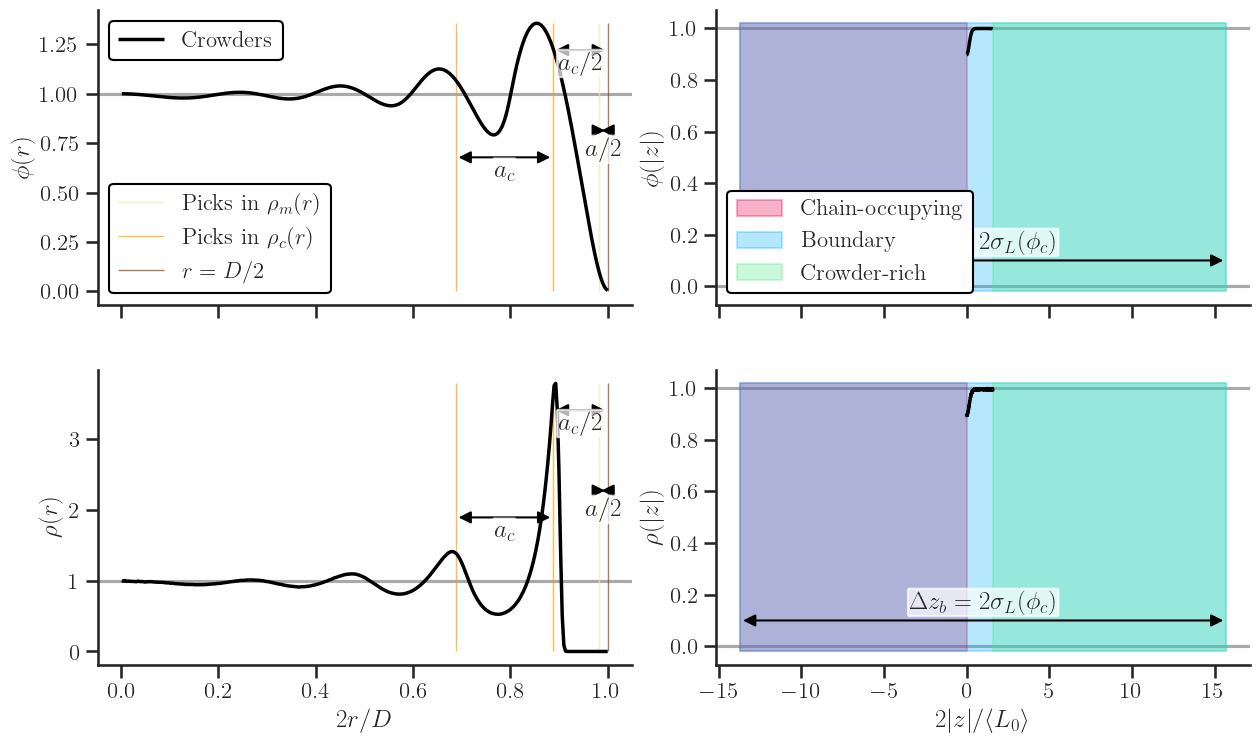

In [3]:
phi_c_sel = 0.3
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': False,
    'grid.color': 'gray',
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
ext = 'pdf'
save_to = './'
font_scale = 1
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.545, 0.745),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
for row, value in chains.iterrows():
    nmon_sel = value['nmon']
    dcrowd_sel = value['dcrowd']
    dcyl_sel = value['dcyl']
    # Filtering and finding
    phi_cond = (systems_wtih_equils['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (systems_wtih_equils['nmon'].isin([nmon_sel]))
    dcrowd_cond = (systems_wtih_equils['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (systems_wtih_equils['dcyl'].isin([dcyl_sel]))
    cond = phi_cond & nmon_cond & dcrowd_cond & dcyl_cond
    chain_fsd = systems_wtih_equils.loc[cond,['nmon','property', 'direction', 'dcyl', 'dcrowd', 'fsdMon-mean', 'fsdMon-var', 'bin_center']]
    # Filtering dataset
    phi_cond = (dist['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (dist['nmon'].isin([nmon_sel]))
    dcrowd_cond = (dist['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (dist['dcyl'].isin([dcyl_sel]))
    var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
    prop_cond = (dist['property'].isin(['Phi', 'Rho']))
    dir_cond = (dist['direction'].isin(['r', 'z']))
    cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.sort_values(by=['dcyl','dcrowd'], inplace=True)
    data.loc[data['direction']=='z','bin_center-dcrowd-recentered'] = \
        data.loc[data['direction']=='z','bin_center-norm']
    data['columns'] = data.apply(
    lambda x: rf"$N={x['nmon']}, {{D}}/{{a}}={x['dcyl']}, {{a_c}}/{{a}}={x['dcrowd']}$", axis=1)
    # filtering z
    var_col_cond = (data['bin_center-fsd_mean']<=1.75)
    z_dir_cond = (data['direction'] == 'z')
    r_dir_cond = (data['direction'] == 'r')
    cond = (var_col_cond & dir_cond) | r_dir_cond
    data = data.loc[cond, :].copy()
    # plotting styl
    x_prop = 'bin_center-fsd_mean'
    # Dropping  values with bin_center-dcrowd-recentered<0
    if x_prop == 'bin_center-dcrowd-recentered':
        data = data.loc[
            data['bin_center-dcrowd-recentered']>=0, :]
    y_prop = 'norm_species_value'
    data.reset_index(inplace=True, drop=True)
    style_attr = 'species'
    style_order = data[style_attr].unique()
    style_order.sort()
    hue_attr = 'phi_c_bulk_round'
    hue_order = data[hue_attr].unique()
    hue_order.sort()
    color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))
    col_attr = 'direction'
    col_order = data[col_attr].unique()
    col_order.sort()
    row_attr = 'property'
    row_order = data[row_attr].unique()
    row_order.sort()
    grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        #col_wrap=2,
        row=row_attr,
        row_order=row_order,
        #hue=hue_attr,
        #hue_order=hue_order,
        markers=False,
        dashes=[(1,0),(3,2)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        color='black',
        #alpha=0.7,
        lw=2.5,
        errorbar=None,
        )
      # uncooment this if you have more than line colors
    #legend_labels = (#[AL[hue_attr]] + list(hue_order) + \
    #                 [AL[style_attr]] + list(style_order)
     #               )
    #for idx, new_label in enumerate(legend_labels):
    #    grid._legend.legendHandles[idx].set_linewidth(7)
    #    grid._legend.texts[idx].set_ha('left')
    #    grid._legend.texts[idx].set_text(new_label)
    #grid.legend.set_title('Species')
    xlims = data.groupby(
            ['property', 'direction', 'columns', 'dcyl', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
    xlims.reset_index(inplace=True)
    #xlims.drop(columns=['bin_center'], inplace=True)
    xlims = xlims.values
    #grid.axes[0][0].legend()
    grid.set_titles('') # turn off titles
    #sns.move_legend(grid, loc='upper left', **move_legend_kws)
    grid = tuner.add_legend_sub_axis(
        grid,
        [[0,0]],
        ['upper left'],
        **legend_global_kws
    )
    for ax, (prop, direction, title, dcyl, dcrowd, x_max, y_max, x_max_not_norm) in zip(grid.axes.flatten(), xlims):
    #    ax.set_title(title)
        ax.set_ylabel(AL[direction+prop+'-norm'])#['symbol'])
        ax.set_xlabel(AL[x_prop+'-'+direction])
        if direction == 'r':
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1,ls=':')
            xlim_extra = (dcyl-(dcyl//dcrowd)*dcrowd)
            # crowders picks
            ljj2cut = round(2**(1/6), 6)
            last_pick = ((dcyl-ljj2cut*dcrowd))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*dcrowd))/dcyl
            line_wall = ax.vlines(
                x=x_max, ymin=0, ymax=y_max, color=AC[6],
                **lines_global_set
            )
            line_crowder = ax.vlines(
                x=last_pick, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
            )
            ax.annotate("", xy=(last_pick, 0.9*y_max), ha='center',
                        va='center', xytext=(x_max,0.9*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.85*y_max, r"$a_c/2$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                    )
            ax.vlines(
                x=before_last, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
                )
            ax.annotate("", xy=(before_last, 0.5*y_max), ha='center',
                        va='center',xytext=(last_pick ,0.5*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+before_last), 0.45*y_max, r"$a_c$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                   )
            # monomers pick
            last_pick = ((dcyl-ljj2cut*1))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*1))/dcyl
            line_monomer = ax.vlines(x=last_pick, ymin=0, ymax=y_max,
                                     color=AC[2], **lines_global_set
                                    )
            ax.annotate("", xy=(last_pick, 0.6*y_max), ha='center',
                        va='center', xytext=(x_max,0.6*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.53*y_max, r"$a/2$", ha="center",
                    va="center", bbox=bbox_global_set
                   )
            #ax.vlines(x=before_last, ymin=0, ymax=y_max, color=AC[2],
            #          **lines_global_set
            #         )
            #ax.annotate("", xy=(before_last, 0.4*y_max), ha='center',
            #            va='center', xytext=(last_pick,0.4*y_max),
            #            xycoords='data', textcoords='data',
            #            arrowprops=dict(arrowstyle='<|-|>', color='black')
            #           )
            #ax.text(0.5*(last_pick+before_last), 0.35*y_max, r"$a$",
            #        ha="center", va="center", bbox=bbox_global_set
            #       )
            if prop == 'Phi':
                ax.legend([line_monomer, line_crowder, line_wall],
                          [r"Picks in $\rho_m(r)$", r"Picks in $\rho_c(r)$",
                           r"$r=D/2$"],
                          **legend_global_kws
                         )
        else:
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1.25)
            ax.axhline(y=0, color='darkgray', zorder=0)#,lw=1.25)
            #ax.grid(
            #    axis='x', which='major', color='black', linestyle='-',lw=1
            #)
            #ax.grid(
            #    axis='y', which='major', color='black', linestyle='-',lw=1
            #)
            fsd_mean_half = 0.5 * chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-mean'].values[0]
            fsdMon_std_dev = chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-var'].values[0]**0.5
            left_bond = 1 - fsdMon_std_dev/fsd_mean_half - dcrowd/fsd_mean_half
            right_bond = 1 + fsdMon_std_dev/fsd_mean_half + dcrowd/fsd_mean_half
            x_range = np.linspace(0, left_bond,100)
            line_chain = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[0], alpha=0.3, zorder=0
            )
            x_range = np.linspace(left_bond, right_bond,100)
            line_bound = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[1], alpha=0.3, zorder=0
            )
            x_range = np.linspace(right_bond, x_max,100)
            line_crowd = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[2], alpha=0.3, zorder=0
            )
            #ax.axvline(x=left_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2)
            #ax_fsd_half = ax.axvline(x=1, ymin=+0.05, ymax=0.95*y_max, color='maroon', zorder=0, lw=2, ls='-.')
            #ax.axvline(x=right_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2, )
            ax.annotate("", xy=(left_bond, 0.1), ha='center', va='center',
                        xytext=(right_bond,0.1), xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            #ax.text(1, 0.22, r"$\Delta z=|0.5\bar{L}(\phi_c)-(\sigma_L(\phi_c)+a_c)|$", ha="center", va="center",
            #        bbox=dict(boxstyle="round",edgecolor='black', color='white'))
            ax.text(1, 0.17, r"$\Delta z_b=2\sigma_L(\phi_c)$", ha="center", va="center",
                    bbox=bbox_global_set
                   )
            if prop == 'Phi':
                #ax.text(1.35, 0.8, r"$\Delta z_b=2\sigma_L(\phi_c)$ ", ha="center", va="center",
                #    bbox=bbox_global_set)
                ax.legend([line_chain,  line_bound, line_crowd],
                          ["Chain-occupying", "Boundary", "Crowder-rich"],
                          loc='lower left',
                           **legend_global_kws
                         )
    output = "-".join(["equilPlot", project, f'radialUndulatoryBehavior-phaseSeparation-nmon{nmon_sel}dcyl{dcyl_sel}dcrowd{dcrowd_sel}phic{phi_c_sel}'])
    grid.fig.tight_layout(pad=0)
    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### Convert the plotted data to Igor friendly

In [ ]:
sel_cols = ['bin_center-dcrowd-recentered', 'species', 'norm_species_value',
       'direction', 'property']
filtered = data.loc[:,sel_cols].copy()
filtered.reset_index(inplace=True, drop=True)
filtered.rename(
    columns={
        'bin_center-dcrowd-recentered':'bin_center',
        'norm_species_value': 'dist_value'
    },inplace=True)
directions = ['r','z']
props = ['Phi', 'Rho']
species = ['Chain', 'Crowders']
dir_prop_pairs = list(itertools.product(directions, props, species))
for dirs, prop, spec in dir_prop_pairs:
    cond = (filtered['direction'] == dirs) & (filtered['property'] == prop) &  (filtered['species'] == spec)
    fiiltered_cond = filtered.loc[cond,:].copy()
    chosen_system = f'N{nmon_sel}D{dcyl_sel}ac{dcrowd_sel}phic{phi_c_sel}'
    fiiltered_cond.drop(columns=['property','direction','species'], inplace=True)
    filename = '-'.join([project, dirs, prop, spec, chosen_system+'.csv'])
    fiiltered_cond.to_csv(filename, index=False)

### Phase separation: Spatial distributions together without the sum rule: not needed

#### All $a_c$ together

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
space_cond = (dist['space_title'].isin(space_titles_chosen))
phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist['property'].isin(['Phi']))
dir_cond = (dist['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r'#sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    grid.axes[0,0].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=2,
                        **move_legend_kws
                    )
                    grid.axes[0,1].legend(
                        grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

##### $a_c\le a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$'
    ]
 
space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist_without_phic0['property'].isin(['Phi']))
dir_cond = (dist_without_phic0['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist_without_phic0.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r'# sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    grid.axes[1,2].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    grid.axes[0,2].legend(
                        grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z-a_c_smaller_or_equal']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

##### $a_c>a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist_without_phic0['property'].isin(['Phi']))
dir_cond = (dist_without_phic0['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist_without_phic0.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-norm']<=0.5)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r' #sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    grid.axes[0,0].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=2,
                        **move_legend_kws
                    )
                    grid.axes[0,1].legend(
                        grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z-a_c_larger']
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### Phase separation: $\phi(r)$ and $\phi(|z|)$ alone: with "a_c ratio indicator": not needed

In [6]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.05,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    '$N=2000, D=60.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:
        for direction in ['z','r']:
            space_cond = (dist['space_title'].isin(space_titles_chosen))
            phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            var_col_cond = (dist['species'].isin(['Monomers', 'Crowders']))
            prop_cond = (dist['property'].isin(['Phi']))
            dir_cond = (dist['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond, :]
            data['dcrowd'].unique()

            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-norm']<=0.5)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'

            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'

            col_attr = 'dcrowd'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("")
                    grid.set_ylabels(AL[direction+prop+'-norm'])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (dcrowd, dcyl, prop, title, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_title(title)
                        if direction == 'r':
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.03,0.03))
                        else:
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.35,0.83))
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    
                    #for idx, ax in enumerate(grid.axes[[2,5]]):  # Targeting only the rightmost column
                    #    #ax.set_yticks([])
                    #    ax_right = ax.twinx()
                    #    if idx == 0:
                    #        ax_right.set_ylabel(r"$a_c \leq 1$")
                    #    else:
                    #        ax_right.set_ylabel(r"$a_c > 1$")
                    #    ax_right.yaxis.label.set_rotation(270)  # Rotate to match default orientation
                    #    ax_right.yaxis.tick_right()
                    #    ax_right.yaxis.set_ticks([])  # Remove ticks
                    #    ax_right.spines["right"].set_visible(False) 
                    #    ax_right.spines["top"].set_visible(False)
                    #    ax_right.yaxis.labelpad = 25  # Adjust this padding value as needed 
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[0].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[0].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='lower left',
                        **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["Phi", direction, project,]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### Phase separation: $\phi(r)$ and $\phi(|z|)$ together: Selected space

In [27]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.8,
        'aspect': 1,#.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.1,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 5.5, #5
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'axes.spines.right': False,
    'axes.spines.top': False
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': False, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2
}
# Filtering dataset
space_titles_chosen = [
    #'$N=500, D=10.0, a_c=0.6$',
    #'$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    #'$N=2000, D=25.0, a_c=2.0$',
    #'$N=2000, D=60.0, a_c=4.0$',
    #'$N=2000, D=60.0, a_c=6.0$'
    ]
chosen_phics = {
    '$N=500, D=10.0, a_c=0.6$': [0, 0.113, 0.226, 0.311, 0.396],
    '$N=500, D=10.0, a_c=0.8$': [0, 0.118, 0.236, 0.295, 0.413],
    '$N=2000, D=25.0, a_c=1.0$': [0, 0.109, 0.217, 0.298, 0.407],
    '$N=2000, D=25.0, a_c=2.0$': [0, 0.118, 0.236, 0.295, 0.414],
    '$N=2000, D=60.0, a_c=4.0$': [0, 0.115, 0.23, 0.316, 0.402],
    '$N=2000, D=60.0, a_c=6.0$': [0, 0.124, 0.185, 0.309, 0.401]
}
plot_context = 'talk'
prop_chosen = 'Phi'
x_prop = 'bin_center-fsd_mean'
ncols = 2
nrows = 1
directions = ['r', 'z']
dir_ful_names = {
    'r': 'Radial direction',
    'z': 'Longitudinal direction'
}
height = plot_params[plot_context]['height']
aspect = plot_params[plot_context]['aspect'] 
sns.reset_defaults()
space_title = space_titles_chosen[0] 
with sns.axes_style('ticks', rc=rc_params):
    with sns.plotting_context(
    plot_context,
    font_scale=plot_params[plot_context]['font_scale']
    ):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(ncols*aspect*height, nrows*height))
        for (letter, direction, ax) in zip(uppercase_letters[:len(directions)], directions, axes.flatten()):
            space_cond = (dist['space_title']==space_title)
            phi_cond = (dist['phi_c_bulk_round-corrected'].isin(chosen_phics[space_title]))
            species_chosen = ['Monomers', 'Crowders']
            var_col_cond = (dist['species'].isin(species_chosen))
            prop_cond = (dist['property'].isin([prop_chosen]))
            dir_cond = (dist['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond,:]
            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-fsd_mean']<=1.5)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'

            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round-corrected'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'
            grid = sns.lineplot(
                data=data,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                hue=hue_attr,
                hue_order=hue_order,
                markers=False,
                dashes=[(1,0),(2,1)],
                legend='full',
                palette=color_palette,
                alpha=0.9,
                lw=3,
                ax=ax
                )
            xlims = data.groupby(
                    ['space_title', 'dcyl', 'property', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
            xlims.reset_index(inplace=True)
            xlims.drop(columns='bin_center', inplace=True)
            xlims = xlims.values
            (title, dcyl, prop, dcrowd, x_max, y_max) = xlims[0]
            grid.set_xlabel(AL[x_prop+'-'+direction])    
            grid.set_ylabel(AL[direction+prop_chosen+'-alpha'])
            grid.set_title(f"({letter}) " + dir_ful_names[direction])
            fig.suptitle(space_title+fr"$: \kappa={round((dcyl-dcrowd)/dcrowd,2)}$")
            handles, labels = grid.get_legend_handles_labels()
            labels[0] = AL[hue_attr]
            labels[-3] = 'Particle type'
            grid.legend_.remove()
            fig.legend(
                handles,
                labels,
                loc='lower left',
                bbox_to_anchor=(1, 0.25),
                **legend_kws
            )            
            fig.align_ylabels()
            fig.tight_layout(pad=0.5)
            output = "-".join(
                [prop_chosen,"r_and_z_together", project,plot_context]
            )
            fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
            plt.close()

### Phase separation: $\phi(r)$ or $\phi(|z|)$ alone: Selected spaces

#### Phi bulk

In [8]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4.5,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    '$N=2000, D=60.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            space_cond = (dist['space_title'].isin(space_titles_chosen))
            phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            #phi_cond = (dist['phi_c_bulk_round-corrected']<=0.4)
            species_chosen = ['Monomers', 'Crowders']
            var_col_cond = (dist['species'].isin(species_chosen))
            prop_chosen = 'Phi'
            prop_cond = (dist['property'].isin([prop_chosen]))
            dir_cond = (dist['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond, :]
            data['dcrowd'].unique()

            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-fsd_mean']<=1.5)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'

            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'
            col_attr = 'space_title'
            col_order = space_titles_chosen
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("{col_name}")
                    grid.set_ylabels(AL[direction+prop_chosen])
                    xlims = data.groupby(
                            ['space_title', 'dcyl', 'property'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (title, dcyl, prop, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_xlabel(AL[x_prop+'-'+direction])
                    grid.fig.align_ylabels()
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[0].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=1,
                            **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[0].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='lower left',
                        **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["Phi", direction, project,]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

#### Phi bulk corrected

In [10]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 5.8,
        'aspect': 1,#.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.1,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 5.5, #5
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
    'axes.spines.right': False,
    'axes.spines.top': False
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2
}
# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    #'$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    #'$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=60.0, a_c=4.0$',
    #'$N=2000, D=60.0, a_c=6.0$'
    ]
chosen_phics = {
    '$N=500, D=10.0, a_c=0.6$': [0.113, 0.226, 0.311, 0.396],
    '$N=500, D=10.0, a_c=0.8$': [0.118, 0.236, 0.295, 0.413],
    '$N=2000, D=25.0, a_c=1.0$': [0.109, 0.217, 0.298, 0.407],
    '$N=2000, D=25.0, a_c=2.0$': [0.118, 0.236, 0.295, 0.414],
    '$N=2000, D=60.0, a_c=4.0$': [0.115, 0.23, 0.316, 0.402],
    '$N=2000, D=60.0, a_c=6.0$': [0.124, 0.185, 0.309, 0.401]
}
plot_context = 'talk'
prop_chosen = 'Phi'
x_prop = 'bin_center-fsd_mean'
ncols = 3
nrows = 1
for direction in ['z','r']:
    height = plot_params[plot_context]['height']
    aspect = plot_params[plot_context]['aspect'] 
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*aspect*height, nrows*height))
            for (letter, space_title, ax) in zip(uppercase_letters[:len(space_titles_chosen)], space_titles_chosen, axes.flatten()):
                space_cond = (dist['space_title']==space_title)
                phi_cond = (dist['phi_c_bulk_round-corrected'].isin(chosen_phics[space_title]))
                species_chosen = ['Monomers', 'Crowders']
                var_col_cond = (dist['species'].isin(species_chosen))
                prop_cond = (dist['property'].isin([prop_chosen]))
                dir_cond = (dist['direction']==direction)
                cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
                data = dist.loc[cond,:]

                # filtering z
                if direction == 'z':
                    var_col_cond = (data['bin_center-fsd_mean']<=1.5)
                    data = data.loc[var_col_cond, :].copy()
                
                y_prop = 'norm_species_value'

                style_attr = 'species'
                style_order = data[style_attr].unique()
                style_order.sort()

                hue_attr = 'phi_c_bulk_round-corrected'
                hue_order = data[hue_attr].unique()
                hue_order.sort()
                color_palette = 'crest'
                grid = sns.lineplot(
                    data=data,
                    x=x_prop,
                    y=y_prop,
                    style=style_attr,
                    style_order=style_order,
                    hue=hue_attr,
                    hue_order=hue_order,
                    markers=False,
                    dashes=[(1,0),(2,1)],
                    legend='full',
                    palette=color_palette,
                    alpha=0.9,
                    lw=3,
                    ax=ax
                    )
                grid.set_title(f"({letter}) " + space_title)
                grid.set_ylabel(AL[direction+prop_chosen+'-alpha'])
                
                xlims = data.groupby(
                        ['space_title', 'dcyl', 'property', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
                xlims.reset_index(inplace=True)
                xlims.drop(columns='bin_center', inplace=True)
                xlims = xlims.values
                (title, dcyl, prop, dcrowd, x_max, y_max) = xlims[0]
                if direction == 'r':
                    ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.0, 1.25))
                else:
                    ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.88, 0.08))
                    
                handles, labels = grid.get_legend_handles_labels()
                labels[0] = AL[hue_attr]
                labels[-3] = 'Particle type'
                grid.legend(
                    handles,
                    labels,
                    #loc='lower left',
                    #bbox_to_anchor=
                    **legend_kws
                )
                grid.set_xlabel(AL[x_prop+'-'+direction])
                fig.align_ylabels()
                fig.tight_layout(pad=0.5)
                output = "-".join(
                    [prop_chosen, direction, project,plot_context]
                )
                fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                plt.close()

### Phase separation: $\phi(r)$ or $\phi(|z|)$ alone: All spaces: Not need

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4.5,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.85,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            phi_cond = (dist['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            species_chosen = ['Monomers', 'Crowders']
            var_col_cond = (dist['species'].isin(species_chosen))
            prop_chosen = 'Phi'
            prop_cond = (dist['property'].isin([prop_chosen]))
            dir_cond = (dist['direction']==direction)
            cond = phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist.loc[cond, :]
            data['dcrowd'].unique()

            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-fsd_mean']<=1.5)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'

            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'crest'

            col_attr = 'space_title'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    grid.set_titles("{col_name}")
                    grid.set_ylabels(AL[direction+prop_chosen])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (title, dcyl, prop, x_max, y_max) in zip(grid.axes.flatten(), xlims):
                        ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    grid.fig.align_ylabels()
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        grid._legend.legendHandles[idx].set_linewidth(3)
                        grid._legend.texts[idx].set_ha('left')
                        grid._legend.texts[idx].set_text(new_label)
                    grid_handles = grid._legend.legendHandles
                    if direction == 'r':
                        grid.axes[0].legend(
                            grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=1,
                            **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    else:
                        grid.axes[0].legend(
                        grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='lower left',
                        **move_legend_kws
                        )
                        grid.axes[1].legend(
                            grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    grid._legend.remove()
                    grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["Phi", direction, project,]
                    )
                    grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

# Heat maps: 2D spatial distributions

## 2D dstributions alone

In [2]:
allInOne_db = \
    '/Users/amirhsi/research_data/'+project+'-analysis-longest/'
phase='ensAvg'
geometry='cylindrical'
group = "all"
topology = 'linear'
project_details = PD[project]
space_dbs = sorted(glob(allInOne_db + project_details['space_pat']+'-'+group+'-'+phase))
print(space_dbs)

['/Users/amirhsi/research_data/SumRuleCyl-analysis-longest/N2000D25.0ac1.0-all-ensAvg']


In [25]:
%%time
# 6 min

### Import averaged chain size measures and merging it with systems
phase = 'ensAvg'
allInOne_db = '../../Datasets/'+project+'-allInOne-longest-last_10_pow_8_tsteps/'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
animate_yes_no = True
hier = project_details['hierarchy']
z_cut = 0.7
r_cut = 1 
species_list = ['Mon', 'Crd']
cartesian_surfaces = ['xy', 'xz', 'yz']
cartesian_dirs = ['x', 'y', 'z']
transverse_directions = ['x', 'y']
transverse_surfaces = ['xz', 'yz']
species_short_name = {'Mon': 'm', 'Crd': 'c'}
cmaps = {
    "Mon": sns.color_palette("OrRd", as_cmap=True),
    "Crd": sns.color_palette("BuGn", as_cmap=True)

}

ext = 'png'
save_to = '../../test_plots/'
font_family = 'sans-serif'

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
}

interp = 'bilinear'
fig_height = 12
ratio = 1.618-0.118 # golden ratio
fig_width = fig_height * ratio
right_ratio = (1/3)*ratio
left_ratio = (2/3)*ratio
animate = True

plot_params = {
    'talk': {
    'font_scale': 1.5,
    },
    'paper': {
    'font_scale': 2,
    }
}
for space_db in space_dbs:
    space = space_db.split("/")[-1].split("-all")[0]
    hist2d_properties = sorted(list(set(['-'.join(file.split('-')[-3:]) for file in glob(space_db + '/' + hier)])))
    hist2d_properties = [prop for prop in hist2d_properties if
                        prop.startswith('xyHist') | prop.startswith('xzHist')
                        | prop.startswith('yzHist')]
    hist2d_properties = [prop for prop in hist2d_properties if prop.endswith('mean.npy')]
    cartesian_edges = sorted(list(set(['-'.join(file.split('-')[-2:]) for file in glob(space_db + '/' + hier)])))
    cartesian_edges = [prop for prop in cartesian_edges if
                    prop.startswith('xEdge') | prop.startswith('yEdge') |
                    prop.startswith('zEdge')]
    properties = cartesian_edges + hist2d_properties
    space_ens_avgs = organizer.sort_filenames(glob(space_db + '/' + hier), fmts=properties)
    ax_names = []
    fsd_phi_c_0 = chainsize_equil.loc[(chainsize_equil['phi_c_bulk_round'] ==0) & (chainsize_equil['space'] == space),'fsdMon-mean'].values
    for ens_avg in space_ens_avgs:
        s_info = project_details['parser'](
            ens_avg[0],
            'ensemble_long',
            geometry,
            group,
            topology,
            ispath=True
        )
        # rounding phi_c data:
        nmon= s_info.nmon
        dcyl = s_info.dcyl
        dcrowd= s_info.dcrowd
        species_size = {
            'Mon': 1.0,
            'Crd': dcrowd
        }
        phi_c_bulk_round = 0
        phi_c_bulk_round_corrected = 0
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk, project_details['divisor'], 3
            )
            phi_c_bulk_round_corrected = round(
                (s_info.ncrowd * 2 * s_info.dcrowd**3) / (3 * (s_info.dcyl-s_info.dcrowd)**2 * s_info.lcyl), 3
            )
        ens_avg_2d_hist: dict[str, np.ndarray] = {}
        # reading ensemble-averaged data into a dict
        for path in ens_avg:
            # property shortname found based on the naming convention:
            prop_ = path.split('all-')[-1].split('-')[0]
            # loading files:
            ens_avg_2d_hist[prop_] = np.load(
                path)#, allow_pickle=True)
            del prop_
        crd_max = {}
        # generating the sum rule in 2D
        for surface in cartesian_surfaces:
            prop_shape = ens_avg_2d_hist[surface+'HistMon'].shape
            ens_avg_2d_hist[surface+'HistSum'] = np.zeros(prop_shape)
            for species in species_list:
                ens_avg_2d_hist[surface+'HistSum'] += (species_size[species]**2 * ens_avg_2d_hist[surface+'Hist'+species])
                if species == 'Crd':
                    crd_max[surface] = ens_avg_2d_hist[surface+'Hist'+species].max()
                ens_avg_2d_hist[surface+'Hist'+species] /= ens_avg_2d_hist[surface+'Hist'+species].max()
            ens_avg_2d_hist[surface+'HistSum'] = ens_avg_2d_hist[surface+'HistSum'] / (species_size['Crd']**2 * crd_max[surface])
                
        # reading edge data and converting to center data:
        for dir_ in cartesian_dirs:
            edges = ens_avg_2d_hist[dir_+'Edge'] 
            # creating center data:
            ens_avg_2d_hist[dir_+'Center'] = (
                edges[:-1] + edges[1:]) / 2
            # normalizing center by its max:
            # In probe phase dcyl_lammps used to create edges.
            # dcyl_lammps = dcyl_real + dwall_bead
            if dir_ in transverse_directions:
                ens_avg_2d_hist[dir_+'Center'] = \
                    (2*ens_avg_2d_hist[dir_+'Center']) / dcyl
            else:
                ens_avg_2d_hist[dir_+'Center'] /= fsd_phi_c_0 # ens_avg_2d_hist[dir_+'Center'].max()
            del edges
        # averaging over transverse surfece (xz and yz)
        species_list_sumrule = species_list
        for species in species_list_sumrule:
            # creating transHist:
            hist_shape = ens_avg_2d_hist['xzHist'+species].shape
            radial_hist = np.zeros(shape=hist_shape)
            # accumulating xzHist and yzHist in transHist
            for surface in transverse_surfaces:
                hist = ens_avg_2d_hist[surface+'Hist'+species] 
                radial_hist += hist
                del hist
            # averaging over transverse hists:
            ens_avg_2d_hist['transHist'+species] = (0.5 * radial_hist)
            # normalizing transHist:
            ens_avg_2d_hist['transHist'+species] /= \
                ens_avg_2d_hist['transHist'+species].sum()
            del radial_hist, hist_shape
        # Cutting z direction data:
        ## z center data:
        z_mask = \
            (ens_avg_2d_hist['zCenter'] >= -z_cut) & (ens_avg_2d_hist['zCenter'] <= z_cut)
        ens_avg_2d_hist['zCenterCut'] = \
            ens_avg_2d_hist['zCenter'][z_mask]
        ## tranverse hists:
        for species in species_list_sumrule:
            for surface in transverse_surfaces:
                ens_avg_2d_hist[surface+'Hist'+species+'Cut'] = \
                    ens_avg_2d_hist[surface+'Hist'+species][:,z_mask]
        # Cutting x and y data:
        ## x and y center data:
        r_mask = {}
        for dir_ in transverse_directions:
            r_mask[dir_] = \
                (ens_avg_2d_hist[f'{dir_}Center'] >= -r_cut) & (ens_avg_2d_hist[f'{dir_}Center'] <= r_cut)
            ens_avg_2d_hist[f'{dir_}CenterCut'] = \
                ens_avg_2d_hist[f'{dir_}Center'][r_mask[dir_]]
            for species in species_list_sumrule:
                ens_avg_2d_hist[dir_+'zHist'+species+'Cut'] = \
                    ens_avg_2d_hist[dir_+'zHist'+species+'Cut'][r_mask[dir_],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species][r_mask['x'],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species+'Cut'][:,r_mask['y']] 
        
        # plotting:
        for plot_context in ['talk']: 
            sns.set_theme(style='ticks', font=font_family)
            with sns.plotting_context(plot_context, font_scale=plot_params[plot_context]['font_scale'], rc=rc_params):
                fig = plt.figure(layout='constrained', figsize=(fig_width, fig_height))
                if plot_context == 'talk':
                    fig.suptitle(fr"$N={nmon}, D={dcyl}, a_c={dcrowd}, \phi_c={phi_c_bulk_round_corrected}$")
                colfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[2, 1])
                # left fig: xz and yz
                leftfig = colfigs[0]
                axes = leftfig.subplots(ncols=1, nrows=4)
                # xz
                for idx, species in enumerate(species_list_sumrule):
                    n_dirs = len(transverse_directions)
                    for idx_d, dir_, in enumerate(transverse_directions):
                        ax = axes[idx*n_dirs+idx_d]
                        rectangle = Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
                        ax.add_patch(rectangle)
                        im = NonUniformImage(
                            ax,
                            interpolation=interp,
                            extent=(-z_cut, z_cut, -1, 1),
                            cmap=cmaps[species])
                        im.set_data(
                            ens_avg_2d_hist['zCenterCut'],
                            ens_avg_2d_hist[f'{dir_}CenterCut'],
                            ens_avg_2d_hist[f'{dir_}zHist{species}Cut'])
                        im.set(clip_path=rectangle, clip_on=True)
                        ax.add_image(im)
                        ax.set_xlim(-z_cut, z_cut)
                        ax.set_ylim(-1.1, 1.1)
                        #ax.set_xlabel(r"$z/z_{max}$")
                        if (species == 'Crd') and (dir_ == 'y'):
                            ax.set_xlabel(r"$z/\langle L_0 \rangle$")
                        else:
                            ax.set_xticklabels("")
                        ax.set_ylabel(fr"$2{dir_}/D$")
                        if species in species_list:
                            ax.set_title(fr"$\rho_{{{species_short_name[species]}}}({dir_},z)$")
                        else:
                            ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}({dir_},z)$")
                # right fig
                rightfig = colfigs[1]
                axes = rightfig.subplots(ncols=1, nrows=2)
                for idx, species in enumerate(species_list_sumrule):
                    ax = axes[idx]
                    circle = Circle((0, 0),1, facecolor='none',
                            edgecolor='black', linewidth=1, alpha=1, zorder=1)
                    ax.add_patch(circle)
                    im = NonUniformImage(
                        ax,
                        interpolation=interp,
                        extent=(-1, 1, -1, 1),
                        cmap=cmaps[species]
                        )
                    im.set_data(
                        ens_avg_2d_hist['xCenterCut'],
                        ens_avg_2d_hist['yCenterCut'],
                        ens_avg_2d_hist[f'xyHist{species}Cut'])
                    im.set(clip_path=circle, clip_on=True)
                    ax.add_image(im)
                    ax.set_box_aspect(1)
                    ax.set_xlim(-1.05, 1.05)
                    ax.set_xticks(np.arange(-1,1.25,0.5))
                    ax.set_ylim(-1.05, 1.05)
                    ax.set_yticks(np.arange(-1,1.25,0.5))
                    #ax.set_xlabel(r"$z/z_{max}$")
                    if species == 'Crd':
                        ax.set_xlabel(r"$2x/D$")
                    else:
                        ax.set_xticklabels("")
                    ax.set_ylabel(r"$2y/D$")
                    if species in species_list:
                        ax.set_title(fr"$\rho_{{{species_short_name[species]}}}(x,y)$")
                        bar_label = fr"$\rho_{{{species_short_name[species]}}}$"
                    else:
                        ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}(x,y)$")
                        bar_label = fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}$" 
                    cbar = rightfig.colorbar(
                        im,
                        ax=ax,
                        cmap=cmaps[species],
                        label=bar_label
                        )
                    #cbar.ax.set_title(bar_label)
                filename = "-".join(
                    [project, "Rho2D", f"N{s_info.nmon}D{s_info.dcyl}a_c{s_info.dcrowd}phi_c{phi_c_bulk_round_corrected}", plot_context])
                output = save_to + filename + '.png' 
                if plot_context == 'talk':
                    ax_names.append(output)
                #output_pdf = save_to + filename + '.pdf' 
                #if animate == animate_yes_no:
                fig.savefig(output, bbox_inches='tight')
                #fig.savefig(output_pdf, bbox_inches='tight')
                plt.close()
    

CPU times: user 10.3 s, sys: 240 ms, total: 10.5 s
Wall time: 10.7 s


In [35]:
space_pngs = glob(save_to+project+'*'+'talk.png')
space_pngs.sort()
output_gif = "-".join(
        ['hist2d', project, s_info.space, plot_context]
) + '.mp4'
common_size = (1824, 1216)  # Example size
with imageio.get_writer(
    save_to + output_gif,
    format='FFMPEG',
    fps=2,
    ) as writer:
        for space_png in space_pngs:
            #print(space_png)
            image = imageio.imread(space_png)
            resized_image = np.array(Image.fromarray(image).resize(common_size))
            #print(image.shape)
            writer.append_data(resized_image)

[rawvideo @ 0x136008050] Stream #0: not enough frames to estimate rate; consider increasing probesize


## Sumrule with 2d distributions

In [ ]:
allInOne_db = \
    '/Users/amirhsi/research_data/'+project+'-analysis-longest/'
phase='ensAvg'
geometry='cylindrical'
group = "all"
topology = 'linear'
project_details = PD[project]
space_dbs = sorted(glob(allInOne_db + project_details['space_pat']+'-'+group+'-'+phase))
print(space_dbs)

['/Users/amirhsi/research_data/SumRuleCyl-analysis-longest/N2000D25.0ac1.0-all-ensAvg']


KeyboardInterrupt: 

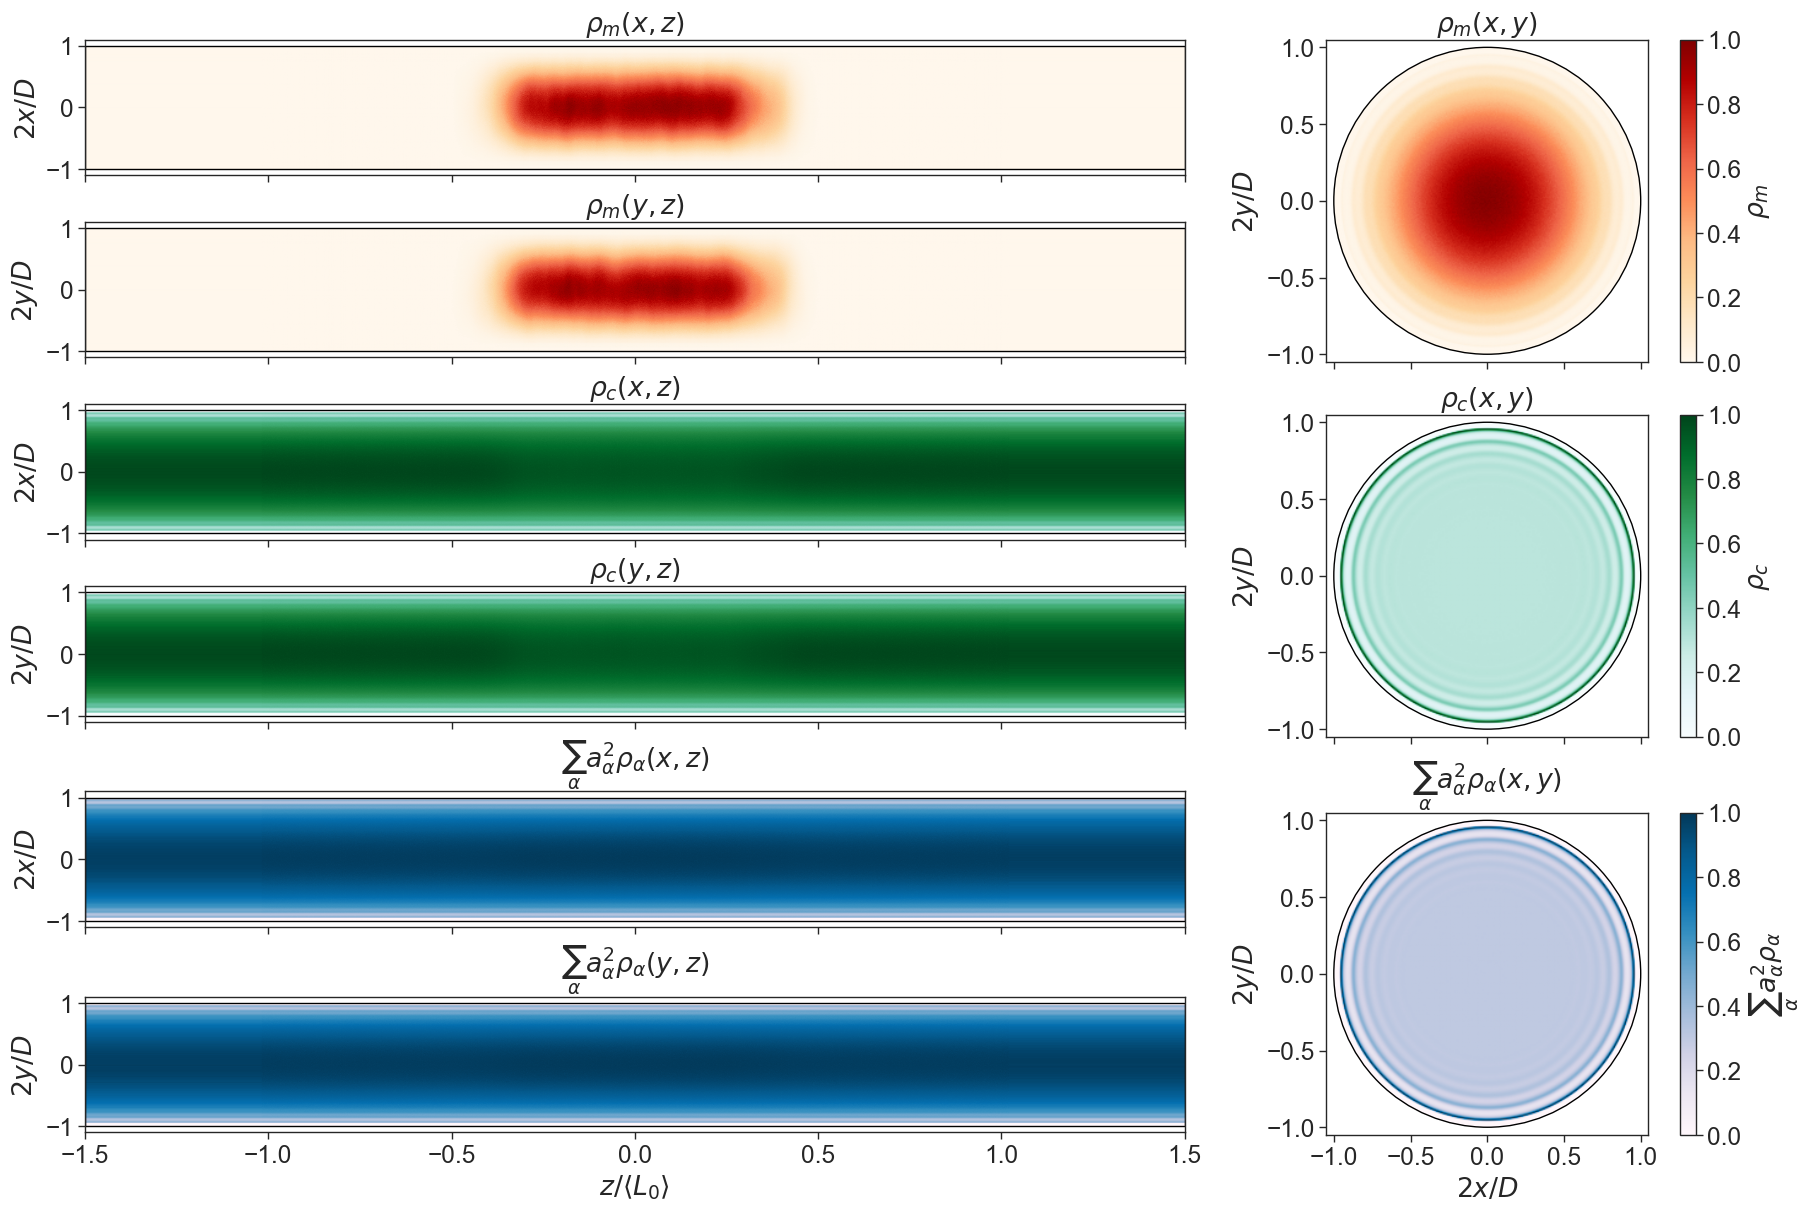

In [8]:
%%time
# 6 min

### Import averaged chain size measures and merging it with systems
phase = 'ensAvg'
allInOne_db = '../../Datasets/'+project+'-allInOne-longest-last_10_pow_8_tsteps/'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
animate_yes_no = False
hier = project_details['hierarchy']
z_cut = 1.5
r_cut = 1 
species_list = ['Mon', 'Crd']
cartesian_surfaces = ['xy', 'xz', 'yz']
cartesian_dirs = ['x', 'y', 'z']
transverse_directions = ['x', 'y']
transverse_surfaces = ['xz', 'yz']
species_short_name = {'Mon': 'm', 'Crd': 'c', 'Sum': ''}
cmaps = {
    "Mon": sns.color_palette("OrRd", as_cmap=True),
    "Sum": sns.color_palette("PuBu", as_cmap=True),
    "Crd": sns.color_palette("BuGn", as_cmap=True)

}

ext = 'png'
save_to = '../../test_plots/'
font_family = 'sans-serif'

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
}

interp = 'bilinear'
fig_height = 12
ratio = 1.618-0.118 # golden ratio
fig_width = fig_height * ratio
right_ratio = (1/3)*ratio
left_ratio = (2/3)*ratio
animate = True

plot_params = {
    'talk': {
    'font_scale': 1,
    },
    'paper': {
    'font_scale': 2,
    }
}
for space_db in space_dbs:
    space = space_db.split("/")[-1].split("-all")[0]
    hist2d_properties = sorted(list(set(['-'.join(file.split('-')[-3:]) for file in glob(space_db + '/' + hier)])))
    hist2d_properties = [prop for prop in hist2d_properties if
                        prop.startswith('xyHist') | prop.startswith('xzHist')
                        | prop.startswith('yzHist')]
    hist2d_properties = [prop for prop in hist2d_properties if prop.endswith('mean.npy')]
    cartesian_edges = sorted(list(set(['-'.join(file.split('-')[-2:]) for file in glob(space_db + '/' + hier)])))
    cartesian_edges = [prop for prop in cartesian_edges if
                    prop.startswith('xEdge') | prop.startswith('yEdge') |
                    prop.startswith('zEdge')]
    properties = cartesian_edges + hist2d_properties
    space_ens_avgs = organizer.sort_filenames(glob(space_db + '/' + hier), fmts=properties)
    ax_names = []
    fsd_phi_c_0 = chainsize_equil.loc[(chainsize_equil['phi_c_bulk_round'] ==0) & (chainsize_equil['space'] == space),'fsdMon-mean'].values
    for ens_avg in space_ens_avgs:
        s_info = project_details['parser'](
            ens_avg[0],
            'ensemble_long',
            geometry,
            group,
            topology,
            ispath=True
        )
        # rounding phi_c data:
        nmon= s_info.nmon
        dcyl = s_info.dcyl
        dcrowd= s_info.dcrowd
        species_size = {
            'Mon': 1.0,
            'Crd': dcrowd
        }
        phi_c_bulk_round = 0
        phi_c_bulk_round_corrected = 0
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk, project_details['divisor'], 3
            )
            phi_c_bulk_round_corrected = round(
                (s_info.ncrowd * 2 * s_info.dcrowd**3) / (3 * (s_info.dcyl-s_info.dcrowd)**2 * s_info.lcyl), 3
            )
        ens_avg_2d_hist: dict[str, np.ndarray] = {}
        # reading ensemble-averaged data into a dict
        for path in ens_avg:
            # property shortname found based on the naming convention:
            prop_ = path.split('all-')[-1].split('-')[0]
            # loading files:
            ens_avg_2d_hist[prop_] = np.load(
                path)#, allow_pickle=True)
            del prop_
        crd_max = {}
        # generating the sum rule in 2D
        for surface in cartesian_surfaces:
            prop_shape = ens_avg_2d_hist[surface+'HistMon'].shape
            ens_avg_2d_hist[surface+'HistSum'] = np.zeros(prop_shape)
            for species in species_list:
                ens_avg_2d_hist[surface+'HistSum'] += (species_size[species]**2 * ens_avg_2d_hist[surface+'Hist'+species])
                if species == 'Crd':
                    crd_max[surface] = ens_avg_2d_hist[surface+'Hist'+species].max()
                ens_avg_2d_hist[surface+'Hist'+species] /= ens_avg_2d_hist[surface+'Hist'+species].max()
            ens_avg_2d_hist[surface+'HistSum'] = ens_avg_2d_hist[surface+'HistSum'] / (species_size['Crd']**2 * crd_max[surface])
                
        # reading edge data and converting to center data:
        for dir_ in cartesian_dirs:
            edges = ens_avg_2d_hist[dir_+'Edge'] 
            # creating center data:
            ens_avg_2d_hist[dir_+'Center'] = (
                edges[:-1] + edges[1:]) / 2
            # normalizing center by its max:
            # In probe phase dcyl_lammps used to create edges.
            # dcyl_lammps = dcyl_real + dwall_bead
            if dir_ in transverse_directions:
                ens_avg_2d_hist[dir_+'Center'] = \
                    (2*ens_avg_2d_hist[dir_+'Center']) / dcyl
            else:
                ens_avg_2d_hist[dir_+'Center'] /= fsd_phi_c_0 # ens_avg_2d_hist[dir_+'Center'].max()
            del edges
        # averaging over transverse surfece (xz and yz)
        species_list_sumrule = species_list + ['Sum']
        for species in species_list_sumrule:
            # creating transHist:
            hist_shape = ens_avg_2d_hist['xzHist'+species].shape
            radial_hist = np.zeros(shape=hist_shape)
            # accumulating xzHist and yzHist in transHist
            for surface in transverse_surfaces:
                hist = ens_avg_2d_hist[surface+'Hist'+species] 
                radial_hist += hist
                del hist
            # averaging over transverse hists:
            ens_avg_2d_hist['transHist'+species] = (0.5 * radial_hist)
            # normalizing transHist:
            ens_avg_2d_hist['transHist'+species] /= \
                ens_avg_2d_hist['transHist'+species].sum()
            del radial_hist, hist_shape
        # Cutting z direction data:
        ## z center data:
        z_mask = \
            (ens_avg_2d_hist['zCenter'] >= -z_cut) & (ens_avg_2d_hist['zCenter'] <= z_cut)
        ens_avg_2d_hist['zCenterCut'] = \
            ens_avg_2d_hist['zCenter'][z_mask]
        ## tranverse hists:
        for species in species_list_sumrule:
            for surface in transverse_surfaces:
                ens_avg_2d_hist[surface+'Hist'+species+'Cut'] = \
                    ens_avg_2d_hist[surface+'Hist'+species][:,z_mask]
        # Cutting x and y data:
        ## x and y center data:
        r_mask = {}
        for dir_ in transverse_directions:
            r_mask[dir_] = \
                (ens_avg_2d_hist[f'{dir_}Center'] >= -r_cut) & (ens_avg_2d_hist[f'{dir_}Center'] <= r_cut)
            ens_avg_2d_hist[f'{dir_}CenterCut'] = \
                ens_avg_2d_hist[f'{dir_}Center'][r_mask[dir_]]
            for species in species_list_sumrule:
                ens_avg_2d_hist[dir_+'zHist'+species+'Cut'] = \
                    ens_avg_2d_hist[dir_+'zHist'+species+'Cut'][r_mask[dir_],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species][r_mask['x'],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species+'Cut'][:,r_mask['y']] 
        
        # plotting:
        for plot_context in ['paper']: #'talk']: 
            sns.set_theme(style='ticks', font=font_family)
            with sns.plotting_context(plot_context, font_scale=plot_params[plot_context]['font_scale'], rc=rc_params):
                fig = plt.figure(layout='constrained', figsize=(fig_width, fig_height))
                if plot_context == 'talk':
                    fig.suptitle(fr"$N={nmon}, D={dcyl}, a_c={dcrowd}, \phi_c={phi_c_bulk_round_corrected}$")
                colfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[2, 1])
                # left fig: xz and yz
                leftfig = colfigs[0]
                axes = leftfig.subplots(ncols=1, nrows=6)
                # xz
                for idx, species in enumerate(species_list_sumrule):
                    n_dirs = len(transverse_directions)
                    for idx_d, dir_, in enumerate(transverse_directions):
                        ax = axes[idx*n_dirs+idx_d]
                        rectangle = Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
                        ax.add_patch(rectangle)
                        im = NonUniformImage(
                            ax,
                            interpolation=interp,
                            extent=(-z_cut, z_cut, -1, 1),
                            cmap=cmaps[species])
                        im.set_data(
                            ens_avg_2d_hist['zCenterCut'],
                            ens_avg_2d_hist[f'{dir_}CenterCut'],
                            ens_avg_2d_hist[f'{dir_}zHist{species}Cut'])
                        im.set(clip_path=rectangle, clip_on=True)
                        ax.add_image(im)
                        ax.set_xlim(-z_cut, z_cut)
                        ax.set_ylim(-1.1, 1.1)
                        #ax.set_xlabel(r"$z/z_{max}$")
                        if (species == 'Sum') and (dir_ == 'y'):
                            ax.set_xlabel(r"$z/\langle L_0 \rangle$")
                        else:
                            ax.set_xticklabels("")
                        ax.set_ylabel(fr"$2{dir_}/D$")
                        if species in species_list:
                            ax.set_title(fr"$\rho_{{{species_short_name[species]}}}({dir_},z)$")
                        else:
                            ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}({dir_},z)$")
                # right fig
                rightfig = colfigs[1]
                axes = rightfig.subplots(ncols=1, nrows=3)
                for idx, species in enumerate(species_list_sumrule):
                    ax = axes[idx]
                    circle = Circle((0, 0),1, facecolor='none',
                            edgecolor='black', linewidth=1, alpha=1, zorder=1)
                    ax.add_patch(circle)
                    im = NonUniformImage(
                        ax,
                        interpolation=interp,
                        extent=(-1, 1, -1, 1),
                        cmap=cmaps[species]
                        )
                    im.set_data(
                        ens_avg_2d_hist['xCenterCut'],
                        ens_avg_2d_hist['yCenterCut'],
                        ens_avg_2d_hist[f'xyHist{species}Cut'])
                    im.set(clip_path=circle, clip_on=True)
                    ax.add_image(im)
                    ax.set_box_aspect(1)
                    ax.set_xlim(-1.05, 1.05)
                    ax.set_xticks(np.arange(-1,1.25,0.5))
                    ax.set_ylim(-1.05, 1.05)
                    ax.set_yticks(np.arange(-1,1.25,0.5))
                    #ax.set_xlabel(r"$z/z_{max}$")
                    if species == 'Sum':
                        ax.set_xlabel(r"$2x/D$")
                    else:
                        ax.set_xticklabels("")
                    ax.set_ylabel(r"$2y/D$")
                    if species in species_list:
                        ax.set_title(fr"$\rho_{{{species_short_name[species]}}}(x,y)$")
                        bar_label = fr"$\rho_{{{species_short_name[species]}}}$"
                    else:
                        ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}(x,y)$")
                        bar_label = fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}$" 
                    cbar = rightfig.colorbar(
                        im,
                        ax=ax,
                        cmap=cmaps[species],
                        label=bar_label
                        )
                    #cbar.ax.set_title(bar_label)
                filename = "-".join(
                    [project, "Rho2D", f"N{s_info.nmon}D{s_info.dcyl}a_c{s_info.dcrowd}phi_c{phi_c_bulk_round_corrected}", plot_context])
                output = save_to + filename + '.png' 
                if plot_context == 'talk':
                    ax_names.append(output)
                output_pdf = save_to + filename + '.pdf' 
                if animate == animate_yes_no:
                    fig.savefig(output, bbox_inches='tight')
                fig.savefig(output_pdf, bbox_inches='tight')
                plt.close()
        if animate == animate_yes_no:
            fps = 2
            duration = 1000 / fps # in milisecond
            output_gif = "-".join(
                    ['hist2d', project, s_info.space, plot_context]
            ) + '.gif'
            with imageio.get_writer(
                save_to + output_gif, mode='I', duration=duration) as writer:
                
                #sorted_files = sorted(ax_names, key=lambda x: SumRuleCyl(
                #    x,'ensemble_long',geometry,
                #    group,
                #    topology,
                #    ispath=True).phi_c_bulk)
                for filename in ax_names:
                    image = imageio.imread(filename)
                    writer.append_data(image)
    